In [1]:
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper
from sklearn.metrics import accuracy_score
from tensorflow import keras
from sklearn import metrics
import tensorflow as tf
import pandas as pd
import numpy as np
import plotting
import hls4ml
import shap
import sys
import os

np.random.seed(77)

import matplotlib.pyplot as plt
import mplhep
plt.style.use(mplhep.style.CMS)

/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/hls4ml_instruct_cnn/hls4ml/converters/__init__.py:15: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!")


In [2]:
options = {
    'v'          : '9',
    'date'       : '2022_09_14',
    'inTagIdent' : '_lTauPtCut18',
    'inTagCalib' : '_lTauPtCut18_uEtacut1.5',
    'caloClNxM'  : '5x9'
}

In [3]:
indir = '/data_CMS/cms/motta/Phase2L1T/'+options['date']+'_v'+options['v']
identdir = indir+'/TauCNNIdentifier'+options['caloClNxM']+'Training'+options['inTagIdent']
calibdir = indir+'/TauCNNCalibrator'+options['caloClNxM']+'Training'+options['inTagCalib']

N = int(options['caloClNxM'].split('x')[0])
M = int(options['caloClNxM'].split('x')[1])

In [4]:
X1_id = np.load(identdir+'/X_CNN_'+options['caloClNxM']+'_forEvaluator.npz')['arr_0']
X2_id = np.load(identdir+'/X_Dense_'+options['caloClNxM']+'_forEvaluator.npz')['arr_0']
Y_id  = np.load(identdir+'/Y_'+options['caloClNxM']+'_forEvaluator.npz')['arr_0']

X1_id = np.float32(X1_id)
X2_id = np.float32(X2_id)
Y_id = np.float32(Y_id)

X1_id_reduced = X1_id[:3000]
X2_id_reduced = X2_id[:3000]
Y_id_reduced = Y_id[:3000]

In [5]:
X1_cal = np.load(calibdir+'/X_CNN_'+options['caloClNxM']+'_forEvaluator.npz')['arr_0']
X2_cal = np.load(calibdir+'/X_Dense_'+options['caloClNxM']+'_forEvaluator.npz')['arr_0']
Y_cal  = np.load(calibdir+'/Y_'+options['caloClNxM']+'_forEvaluator.npz')['arr_0']

X1_cal = np.float32(X1_cal)
X2_cal = np.float32(X2_cal)
Y_cal = np.float32(Y_cal)

X1_cal_reduced = X1_cal[:3000]
X2_cal_reduced = X2_cal[:3000]
Y_cal_reduced = Y_cal[:3000]

In [6]:
CNN = keras.models.load_model(identdir+'/CNNmodel', compile=False)
QCNN = keras.models.load_model(identdir+'/QCNNmodel', compile=False)

DNNident = keras.models.load_model(identdir+'/DNNmodel', compile=False)
QDNNident = keras.models.load_model(identdir+'/QDNNmodel', compile=False)

DNNcalib = keras.models.load_model(calibdir+'/TauCNNCalibrator', compile=False)
QDNNcalib = keras.models.load_model(calibdir+'/TauCNNQCalibrator', compile=False)

2022-09-27 12:31:45.763004: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /grid_mnt/opt__exp_soft/llr/python/3.9.9/lib/python3.9/site-packages/cv2/../../lib64:/opt/exp_soft/llr/python/3.9.9/lib/vtk:/opt/exp_soft/llr/python/3.9.9/lib:/usr/lib64/classads:/usr/lib64:/usr/lib
2022-09-27 12:31:45.763045: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-09-27 12:31:45.763422: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) t

# NON-QUANTIZED MODELS FIRST

## Create HLS model for the identification CNN and DNN - NON-QUANTIZED

Interpreting Model
Topology:
Layer name: TowerClusterImage, layer type: Input
Layer name: CNNlayer1, layer type: Conv2D
  -> Activation (linear), layer name: CNNlayer1
Layer name: BN_CNNlayer1, layer type: BatchNormalization
Layer name: RELU_CNNlayer1, layer type: Activation
Layer name: MP_CNNlayer1, layer type: MaxPooling2D
Layer name: CNNlayer2, layer type: Conv2D
  -> Activation (linear), layer name: CNNlayer2
Layer name: BN_CNNlayer2, layer type: BatchNormalization
Layer name: RELU_CNNlayer2, layer type: Activation
Layer name: TowerClusterPosition, layer type: Input
Layer name: middleMan, layer type: Concatenate
{'Model': {'Precision': 'ap_fixed<19,7>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'TowerClusterImage': {'Precision': 'ap_fixed<16,9>', 'Strategy': 'Latency', 'ReuseFactor': 1, 'Trace': True}, 'CNNlayer1': {'Precision': 'ap_fixed<19,7>', 'ReuseFactor': 1, 'Strategy': 'Latency', 'Trace': True}, 'CNNlayer1_linear': {'Precision': 'ap_fixed<19,7>', 'ReuseFactor':

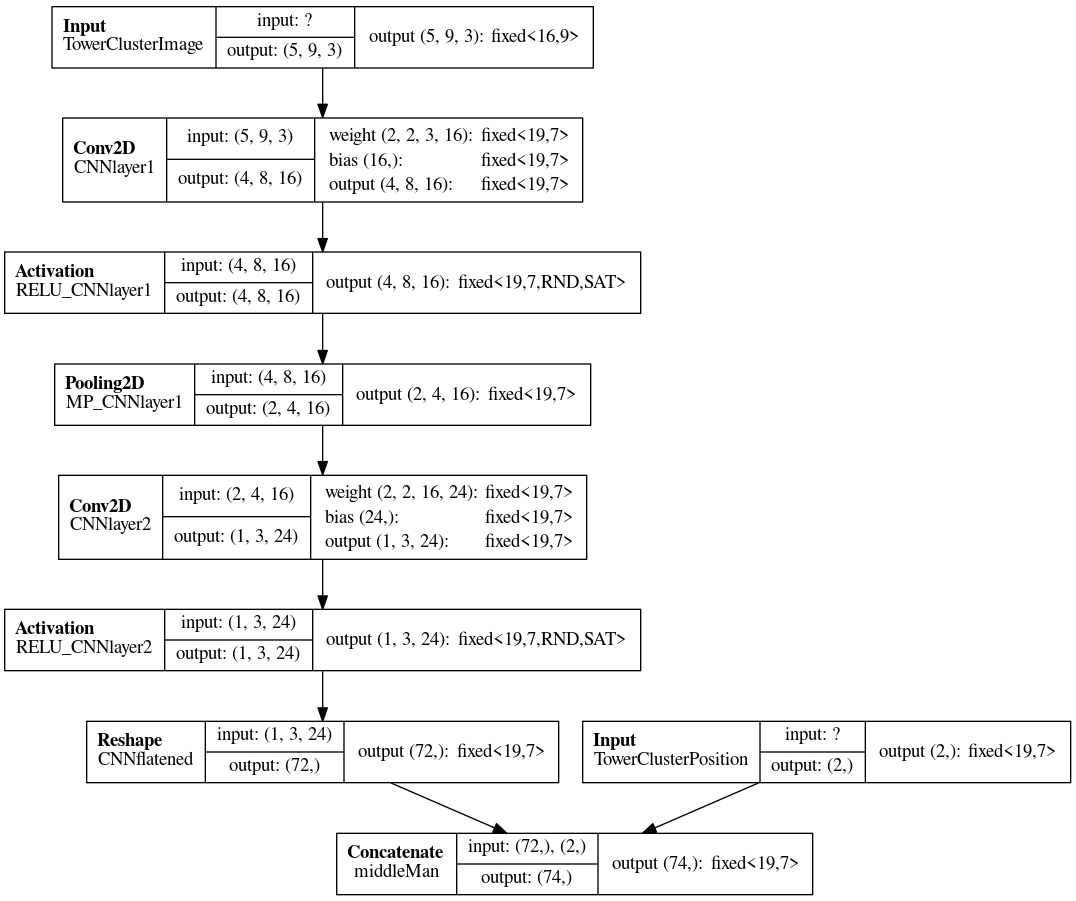

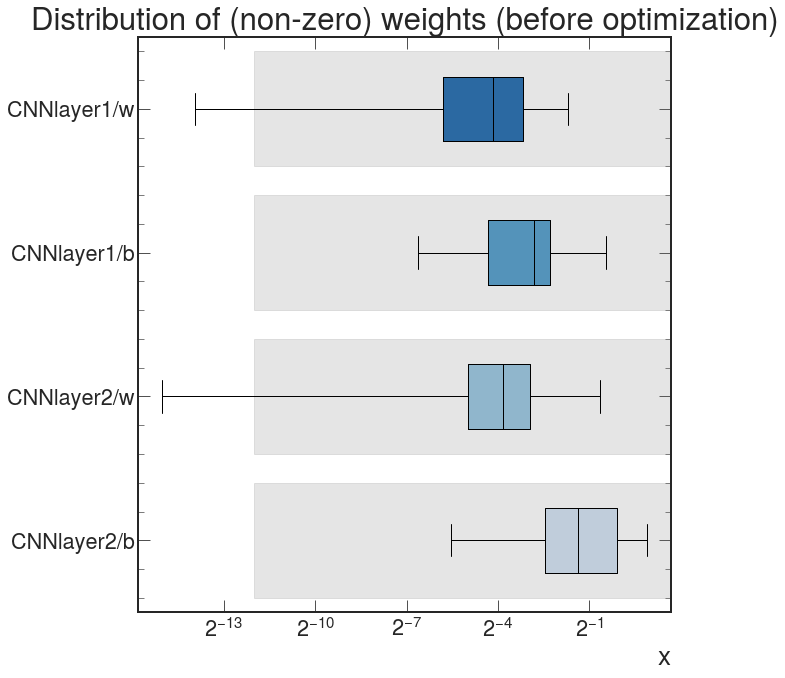

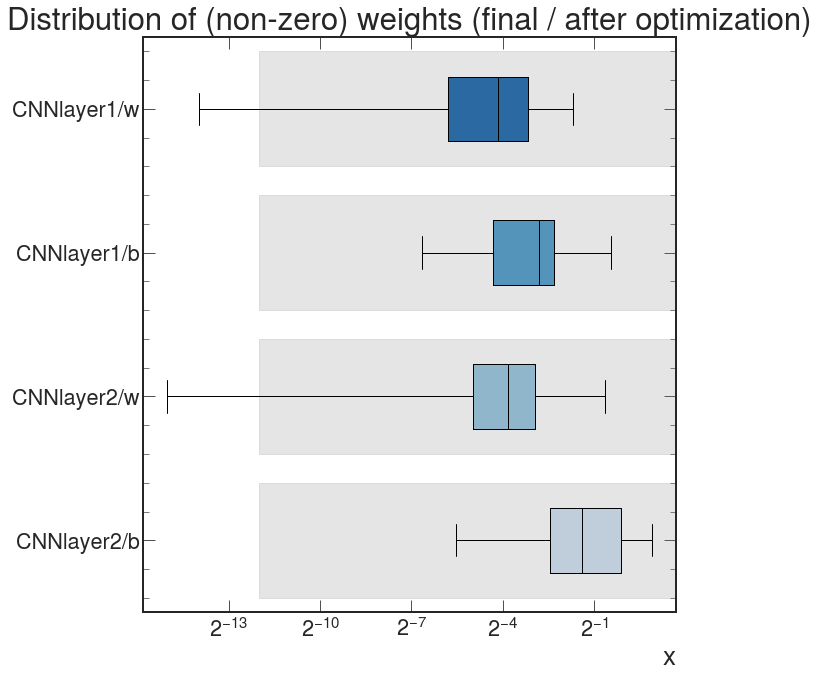

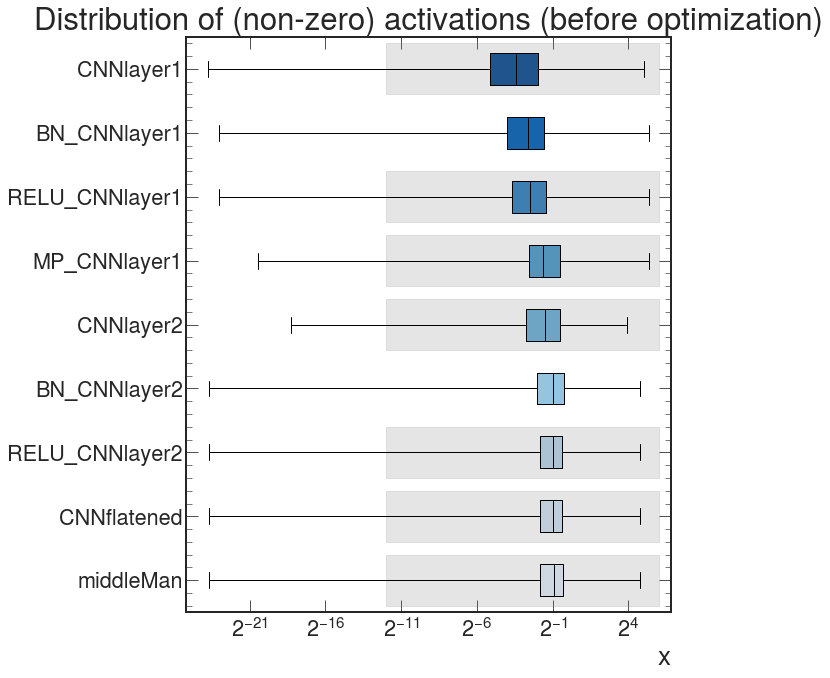

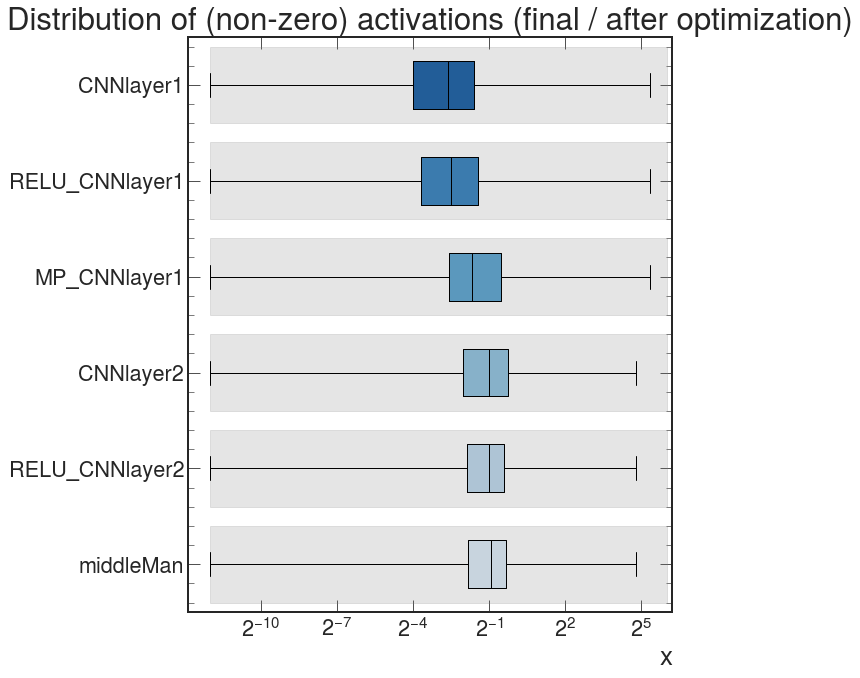

In [7]:
############################## Pass non-quantized CNN model through hls4ml ##############################

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=['Activation'],
                                                                                  rounding_mode='AP_RND',
                                                                                  saturation_mode='AP_SAT')

# baseline model
CNN_hls_cfg = hls4ml.utils.config_from_keras_model(CNN, granularity='name')
CNN_hls_cfg['Model']['Precision'] = 'ap_fixed<19,7>'
CNN_hls_cfg['Model']['ReuseFactor'] = 1
for Layer in CNN_hls_cfg['LayerName'].keys():
    CNN_hls_cfg['LayerName'][Layer]['Strategy'] = 'Latency'
    CNN_hls_cfg['LayerName'][Layer]['ReuseFactor'] = 1
    CNN_hls_cfg['LayerName'][Layer]['Trace'] = True
    CNN_hls_cfg['LayerName'][Layer]['Precision'] = 'ap_fixed<19,7>'
CNN_hls_cfg['LayerName']['TowerClusterImage']['Precision'] = 'ap_fixed<16,9>'
CNN_hls_cfg['LayerName']['middleMan']['Precision'] = 'ap_fixed<19,7>'
CNN_hls_cfg['LayerName']['middleMan']['Strategy'] = 'Stable'

print(CNN_hls_cfg)

CNN_cfg = hls4ml.converters.create_config(backend='Vivado')
CNN_cfg['IOType']     = 'io_parallel' # Must set this if using CNNs!
CNN_cfg['HLSConfig']  = CNN_hls_cfg
CNN_cfg['KerasModel'] = CNN
CNN_cfg['OutputDir']  = identdir+'/CNNmodel_HLS/'
CNN_cfg['Part']       = 'xcvu13p-fhgb2104-2L-e'
CNN_cfg['XilinxPart'] = 'xcvu13p-fhgb2104-2L-e'

CNN_hls = hls4ml.converters.keras_to_hls(CNN_cfg)

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=[])
CNN_hls.compile()

hls4ml.model.profiling.numerical(model=CNN, hls_model=CNN_hls, X=[X1_id_reduced,X2_id_reduced])
hls4ml.utils.plot_model(CNN_hls, show_shapes=True, show_precision=True, to_file=None)

Interpreting Model
Topology:
Layer name: CNNflattened, layer type: Input
Layer name: DNNlayer1, layer type: Dense
  -> Activation (linear), layer name: DNNlayer1
Layer name: RELU_DNNlayer1, layer type: Activation
Layer name: DNNlayer2, layer type: Dense
  -> Activation (linear), layer name: DNNlayer2
Layer name: RELU_DNNlayer2, layer type: Activation
Layer name: DNNout, layer type: Dense
  -> Activation (linear), layer name: DNNout
Layer name: sigmoid_DNNout, layer type: Activation
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'CNNflattened': {'Precision': {'result': 'ap_fixed<16,6>'}, 'Strategy': 'Latency', 'ReuseFactor': 1, 'Trace': True}, 'DNNlayer1': {'Precision': {'weight': 'ap_fixed<6,1>', 'bias': 'ap_fixed<16,6>', 'result': 'ap_fixed<9,6>', 'accum': 'ap_fixed<14,5>'}, 'ReuseFactor': 1, 'Strategy': 'Latency', 'Trace': True}, 'DNNlayer1_linear': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_

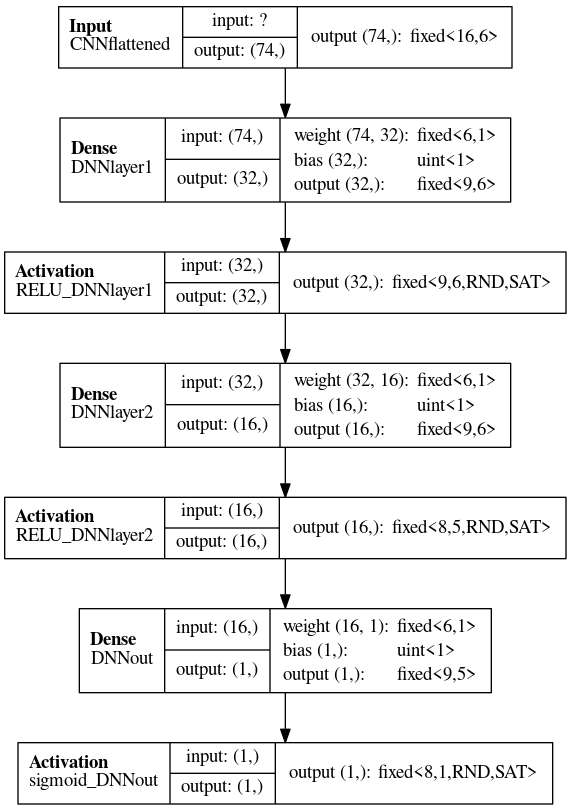

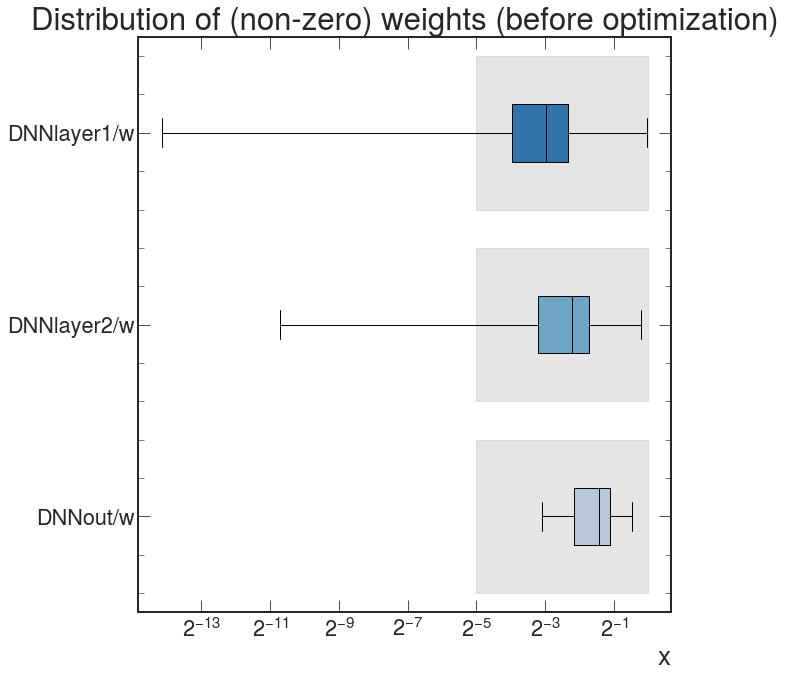

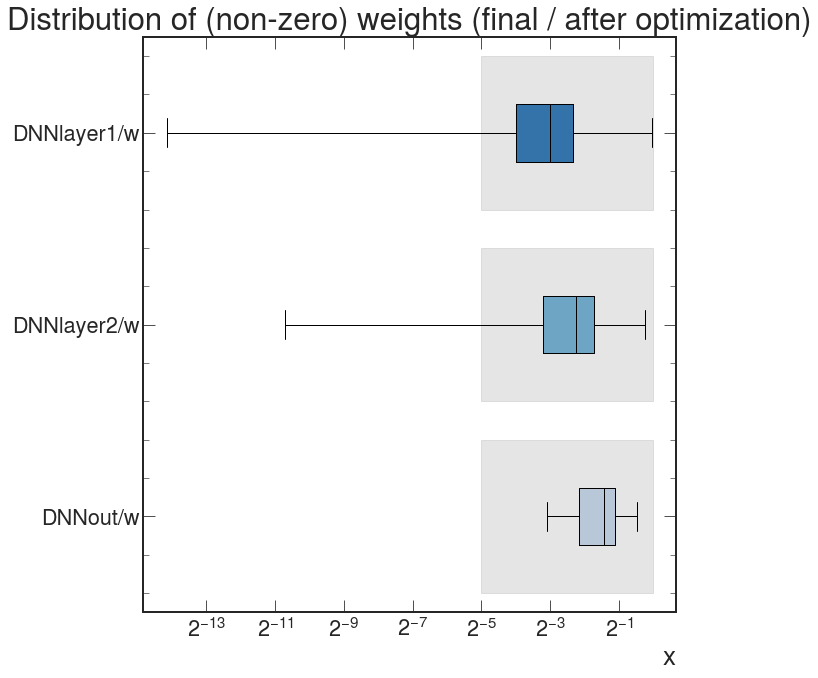

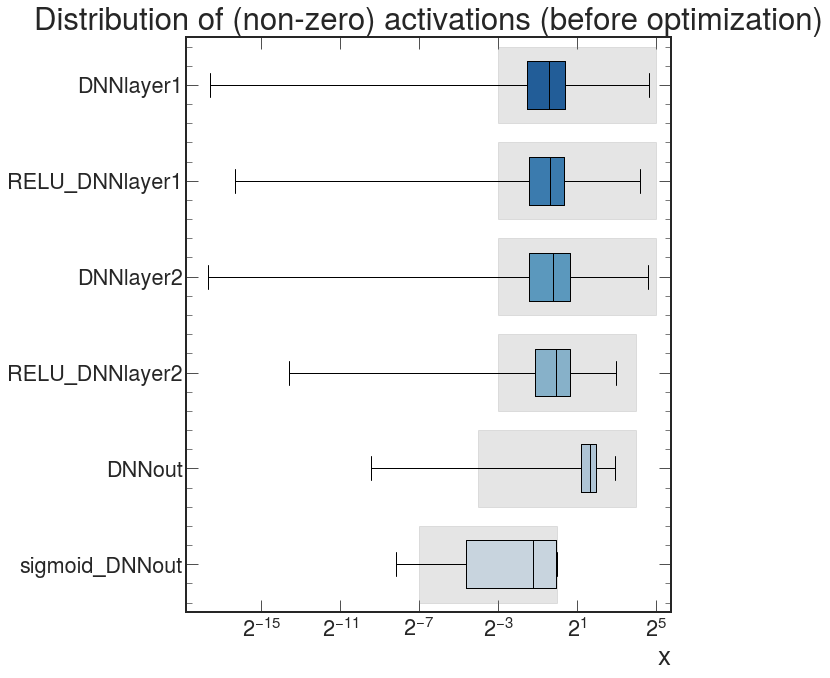

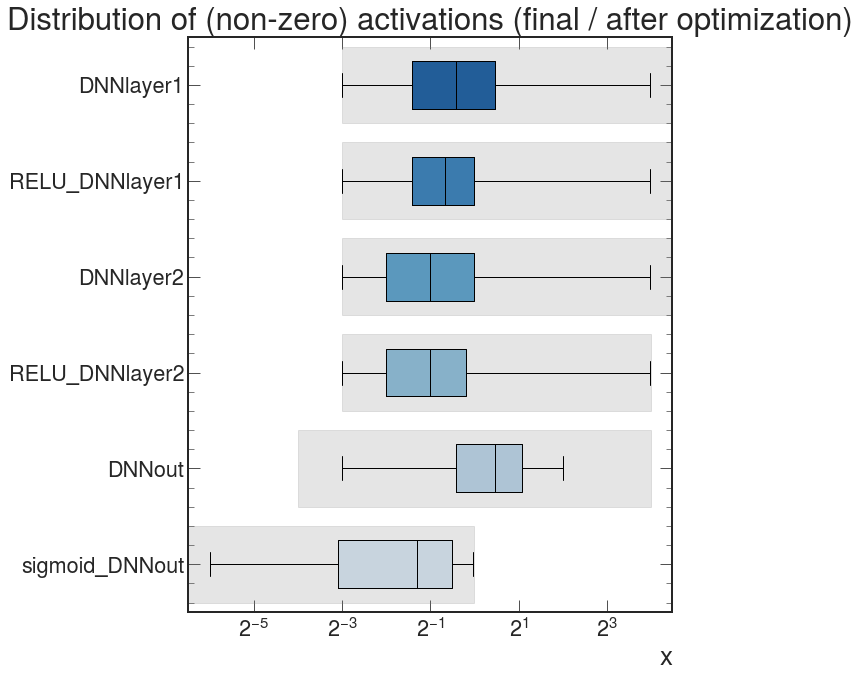

In [8]:
############################## Pass non-quantized identification DNN model through hls4ml ##############################

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=['Activation'],
                                                                                  rounding_mode='AP_RND',
                                                                                  saturation_mode='AP_SAT')

# baseline model
id_DNN_hls_cfg = hls4ml.utils.config_from_keras_model(DNNident, granularity='name')
id_DNN_hls_cfg['Model']['Precision'] = 'ap_fixed<16,6>'
id_DNN_hls_cfg['Model']['ReuseFactor'] = 1
for Layer in id_DNN_hls_cfg['LayerName'].keys():
    id_DNN_hls_cfg['LayerName'][Layer]['Strategy'] = 'Latency'
    id_DNN_hls_cfg['LayerName'][Layer]['ReuseFactor'] = 1
    id_DNN_hls_cfg['LayerName'][Layer]['Trace'] = True
id_DNN_hls_cfg['LayerName']['DNNlayer1']['Precision']['weight'] = 'ap_fixed<6,1>'
id_DNN_hls_cfg['LayerName']['DNNlayer1']['Precision']['result'] = 'ap_fixed<9,6>'
id_DNN_hls_cfg['LayerName']['DNNlayer1']['Precision']['accum'] = 'ap_fixed<14,5>'
id_DNN_hls_cfg['LayerName']['RELU_DNNlayer1']['Precision'] = 'ap_fixed<9,6>'

id_DNN_hls_cfg['LayerName']['DNNlayer2']['Precision']['weight'] = 'ap_fixed<6,1>'
id_DNN_hls_cfg['LayerName']['DNNlayer2']['Precision']['result'] = 'ap_fixed<9,6>'
id_DNN_hls_cfg['LayerName']['DNNlayer2']['Precision']['accum'] = 'ap_fixed<10,5>'
id_DNN_hls_cfg['LayerName']['RELU_DNNlayer2']['Precision'] = 'ap_fixed<8,5>'

id_DNN_hls_cfg['LayerName']['DNNout']['Precision']['weight'] = 'ap_fixed<6,1>'
id_DNN_hls_cfg['LayerName']['DNNout']['Precision']['result'] = 'ap_fixed<9,5>'
id_DNN_hls_cfg['LayerName']['DNNout']['Precision']['accum'] = 'ap_fixed<6,3>'

id_DNN_hls_cfg['LayerName']['sigmoid_DNNout']['Precision'] = 'ap_fixed<8,1>'
id_DNN_hls_cfg['LayerName']['sigmoid_DNNout']['Strategy'] = 'Stable'

print(id_DNN_hls_cfg)

id_DNN_cfg = hls4ml.converters.create_config(backend='Vivado')
id_DNN_cfg['IOType']     = 'io_parallel'
id_DNN_cfg['HLSConfig']  = id_DNN_hls_cfg
id_DNN_cfg['KerasModel'] = DNNident
id_DNN_cfg['OutputDir']  = identdir+'/DNNmodel_HLS/'
id_DNN_cfg['Part']       = 'xcvu13p-fhgb2104-2L-e'
id_DNN_cfg['XilinxPart'] = 'xcvu13p-fhgb2104-2L-e'

DNNident_hls = hls4ml.converters.keras_to_hls(id_DNN_cfg)

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=[])
DNNident_hls.compile()

id_CNNoutput = np.array(CNN([X1_id_reduced,X2_id_reduced]))

hls4ml.model.profiling.numerical(model=DNNident, hls_model=DNNident_hls, X=id_CNNoutput)
hls4ml.utils.plot_model(DNNident_hls, show_shapes=True, show_precision=True, to_file=None)

## Create HLS model for the calibration DNN - NON-QUANTIZED

Interpreting Model
Topology:
Layer name: CNNflattened, layer type: Input
Layer name: DNNlayer1, layer type: Dense
  -> Activation (linear), layer name: DNNlayer1
Layer name: RELU_DNNlayer1, layer type: Activation
Layer name: DNNlayer2, layer type: Dense
  -> Activation (linear), layer name: DNNlayer2
Layer name: RELU_DNNlayer2, layer type: Activation
Layer name: DNNout, layer type: Dense
  -> Activation (linear), layer name: DNNout
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'CNNflattened': {'Precision': 'ap_fixed<20,7>', 'Strategy': 'Resources', 'ReuseFactor': 1, 'Trace': True}, 'DNNlayer1': {'Precision': {'weight': 'ap_fixed<6,1>', 'bias': 'ap_fixed<16,6>', 'result': 'ap_fixed<16,7>', 'accum': 'ap_fixed<20,10>'}, 'ReuseFactor': 1, 'Strategy': 'Resources', 'Trace': True}, 'RELU_DNNlayer1': {'Precision': 'ap_fixed<16,7>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>', 'Strategy': 'Resources', 'Trace': True}, 'DNN

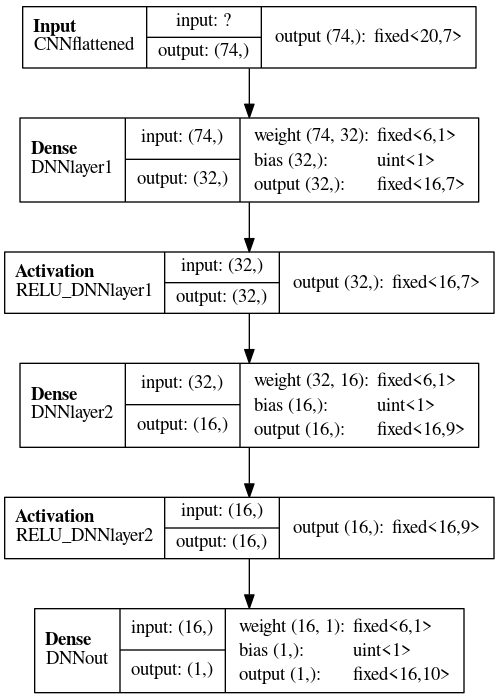

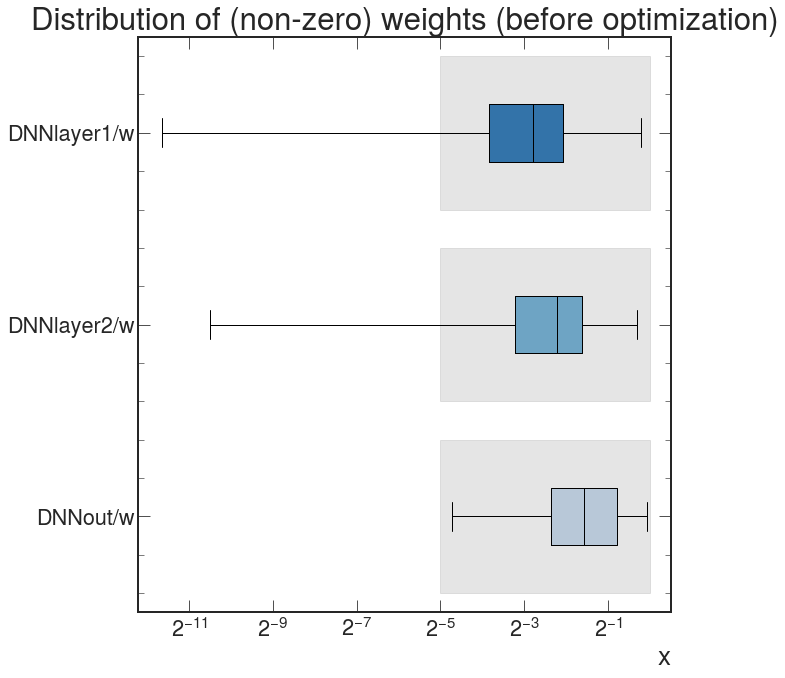

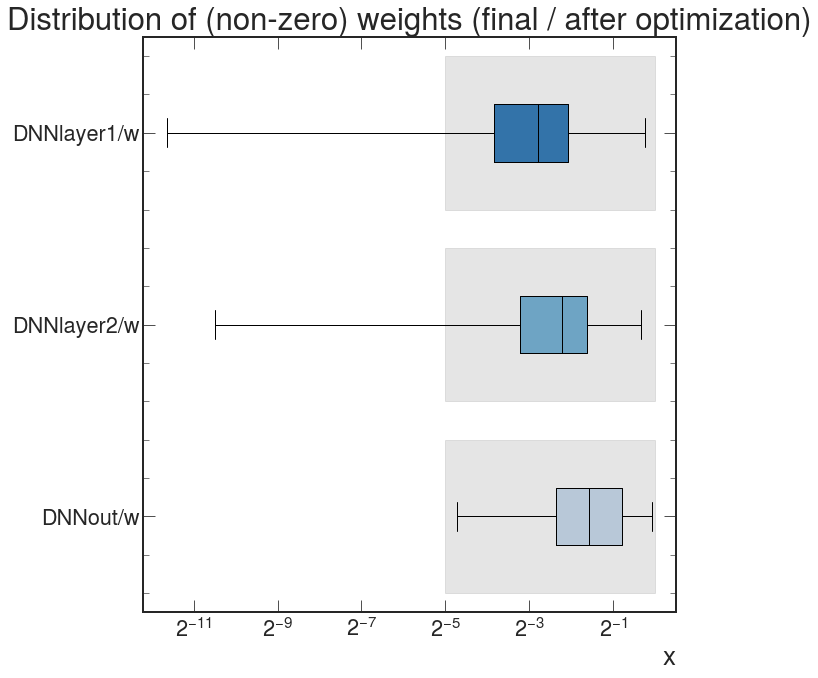

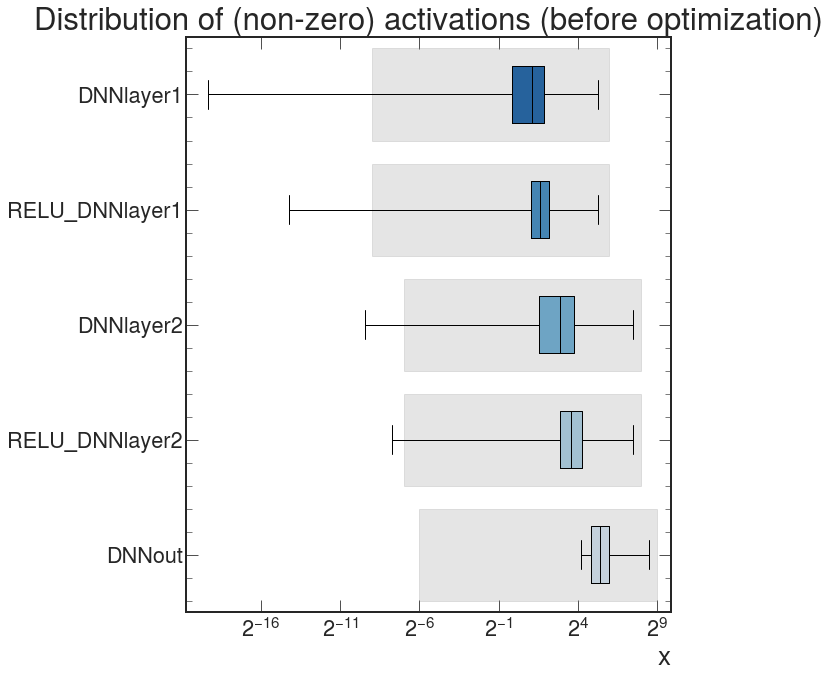

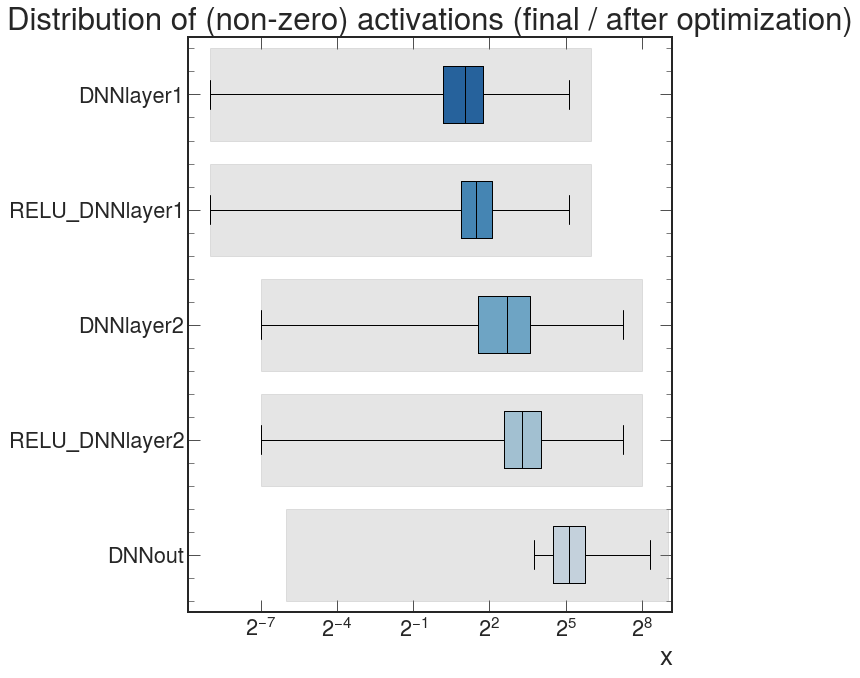

In [9]:
############################## Pass non-quantized calibration DNN model through hls4ml ##############################

# hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=['Activation'],
#                                                                                   rounding_mode='AP_RND',
#                                                                                   saturation_mode='AP_SAT')

# baseline model
cal_DNN_hls_cfg = hls4ml.utils.config_from_keras_model(DNNcalib, granularity='name')
cal_DNN_hls_cfg['Model']['Precision'] = 'ap_fixed<16,6>'
cal_DNN_hls_cfg['Model']['ReuseFactor'] = 1
for Layer in cal_DNN_hls_cfg['LayerName'].keys():
    cal_DNN_hls_cfg['LayerName'][Layer]['Strategy'] = 'Resources'
    cal_DNN_hls_cfg['LayerName'][Layer]['ReuseFactor'] = 1
    cal_DNN_hls_cfg['LayerName'][Layer]['Trace'] = True

cal_DNN_hls_cfg['LayerName']['CNNflattened']['Precision'] = 'ap_fixed<20,7>'

cal_DNN_hls_cfg['LayerName']['DNNlayer1']['Precision']['weight'] = 'ap_fixed<6,1>'
cal_DNN_hls_cfg['LayerName']['DNNlayer1']['Precision']['result'] = 'ap_fixed<16,7>'
cal_DNN_hls_cfg['LayerName']['DNNlayer1']['Precision']['accum'] = 'ap_fixed<20,10>'
cal_DNN_hls_cfg['LayerName']['RELU_DNNlayer1']['Precision'] = 'ap_fixed<16,7>'

cal_DNN_hls_cfg['LayerName']['DNNlayer2']['Precision']['weight'] = 'ap_fixed<6,1>'
cal_DNN_hls_cfg['LayerName']['DNNlayer2']['Precision']['result'] = 'ap_fixed<16,9>'
cal_DNN_hls_cfg['LayerName']['DNNlayer2']['Precision']['accum'] = 'ap_fixed<20,10>'
cal_DNN_hls_cfg['LayerName']['RELU_DNNlayer2']['Precision'] = 'ap_fixed<16,9>'

cal_DNN_hls_cfg['LayerName']['DNNout']['Precision']['weight'] = 'ap_fixed<6,1>'
cal_DNN_hls_cfg['LayerName']['DNNout']['Precision']['result'] = 'ap_fixed<16,10>'
cal_DNN_hls_cfg['LayerName']['DNNout']['Precision']['accum'] = 'ap_fixed<20,10>'
cal_DNN_hls_cfg['LayerName']['DNNout']['Strategy'] = 'Stable'

cal_DNN_hls_cfg['LayerName'].pop('DNNlayer1_linear')
cal_DNN_hls_cfg['LayerName'].pop('DNNlayer2_linear')
cal_DNN_hls_cfg['LayerName'].pop('DNNout_linear')

print(cal_DNN_hls_cfg)

cal_DNN_cfg = hls4ml.converters.create_config(backend='Vivado')
cal_DNN_cfg['IOType']     = 'io_stream'
cal_DNN_cfg['HLSConfig']  = cal_DNN_hls_cfg
cal_DNN_cfg['KerasModel'] = DNNcalib
cal_DNN_cfg['OutputDir']  = calibdir+'/DNNmodel_HLS/'
cal_DNN_cfg['Part']       = 'xcvu13p-fhgb2104-2L-e'
cal_DNN_cfg['XilinxPart'] = 'xcvu13p-fhgb2104-2L-e'

DNNcalib_hls = hls4ml.converters.keras_to_hls(cal_DNN_cfg)

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=[])
DNNcalib_hls.compile()

cal_CNNoutput = np.array(CNN([X1_cal_reduced,X2_cal_reduced]))

hls4ml.model.profiling.numerical(model=DNNcalib, hls_model=DNNcalib_hls, X=cal_CNNoutput)
hls4ml.utils.plot_model(DNNcalib_hls, show_shapes=True, show_precision=True, to_file=None)

# QUANTIZED MODELS THEN

## Create HLS model for the identification CNN and DNN - QUANTIZED

Interpreting Model
Topology:
Layer name: TowerClusterImage, layer type: Input
Layer name: CNNpBNlayer1, layer type: QConv2DBatchnorm
  -> Activation (linear), layer name: CNNpBNlayer1
Layer name: RELU_CNNpBNlayer1, layer type: QActivation
  -> Activation (quantized_relu(10,7)), layer name: RELU_CNNpBNlayer1
Layer name: MP_CNNpBNlayer1, layer type: MaxPooling2D
Layer name: CNNpBNlayer2, layer type: QConv2DBatchnorm
  -> Activation (linear), layer name: CNNpBNlayer2
Layer name: RELU_CNNpBNlayer2, layer type: QActivation
  -> Activation (quantized_relu(9,6)), layer name: RELU_CNNpBNlayer2
Layer name: TowerClusterPosition, layer type: Input
Layer name: middleMan, layer type: Concatenate
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'TowerClusterImage': {'Precision': 'ap_fixed<16,9>', 'Strategy': 'Latency', 'ReuseFactor': 1, 'Trace': True}, 'CNNpBNlayer1': {'Precision': 'ap_fixed<16,7>', 'ReuseFactor': 1, 'Strategy': 'Latency', 'Trace': Tr

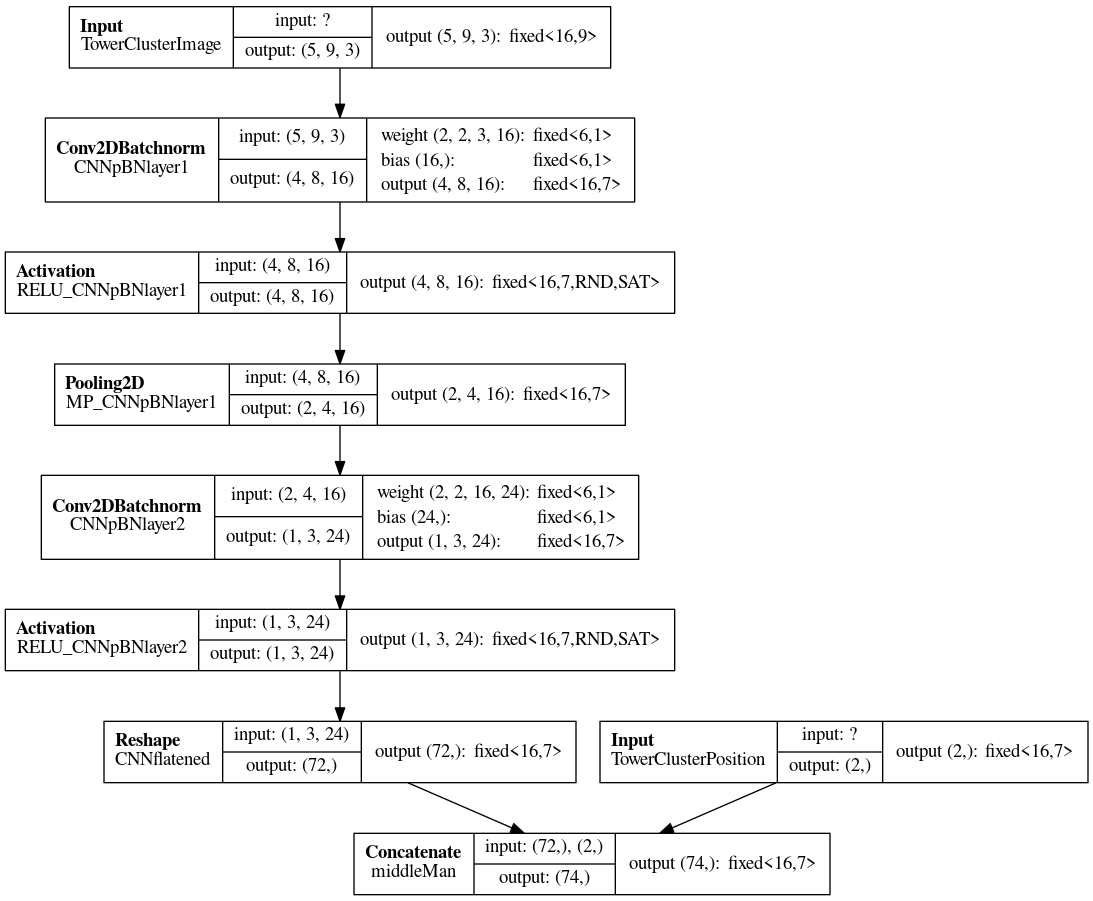

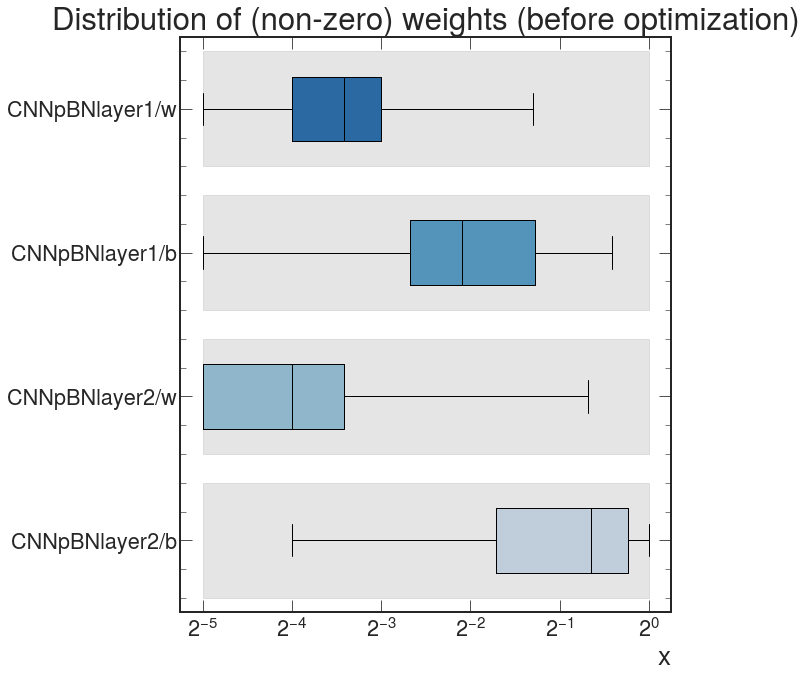

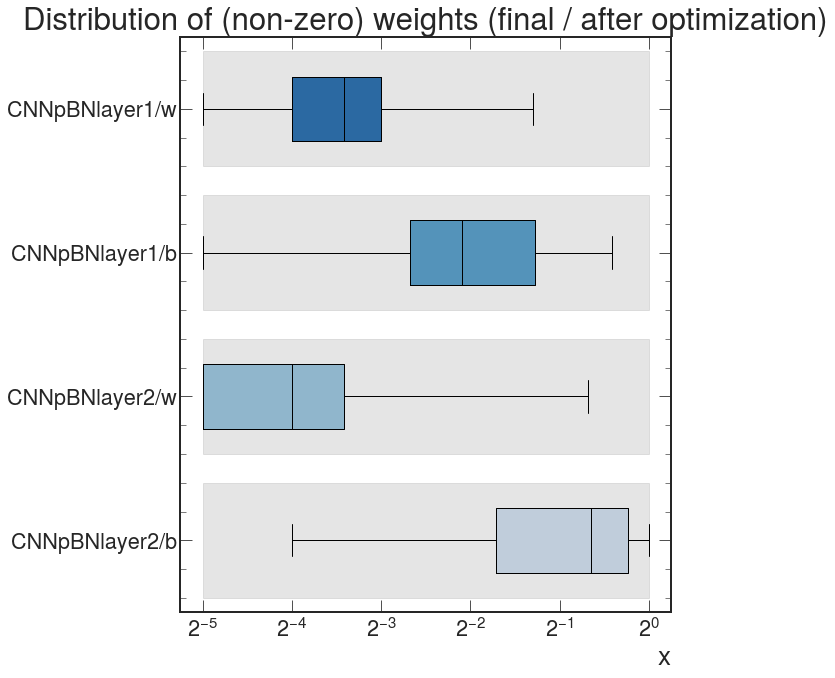

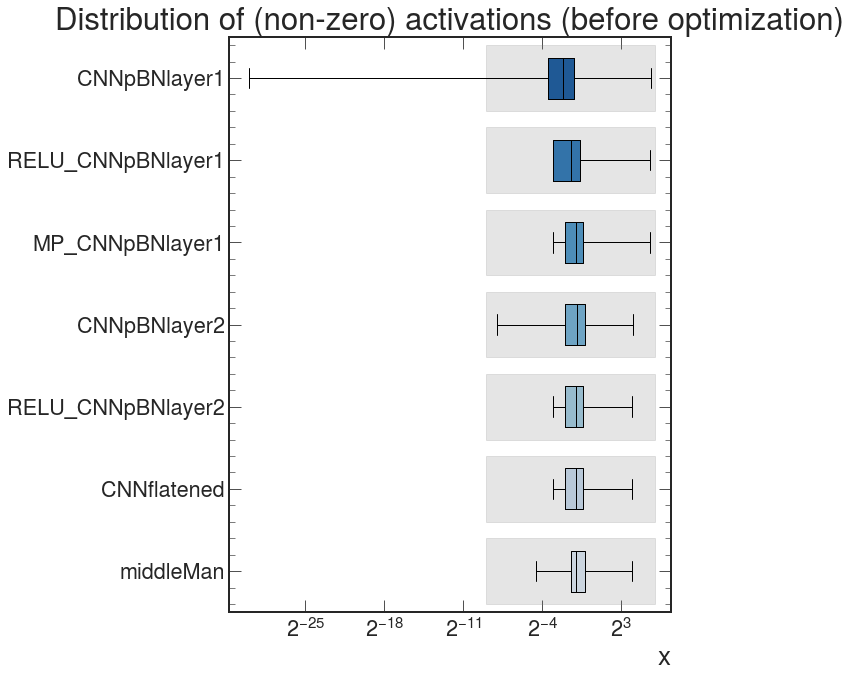

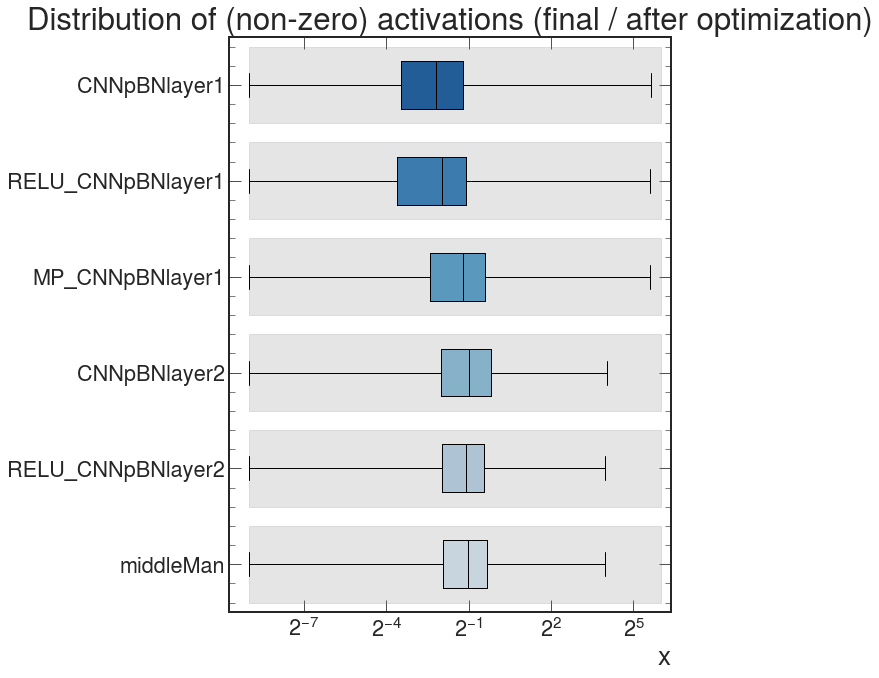

In [10]:
############################## Pass quantized CNN model through hls4ml ##############################

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=['Activation'],
                                                                                  rounding_mode='AP_RND',
                                                                                  saturation_mode='AP_SAT')

# baseline model
QCNN_hls_cfg = hls4ml.utils.config_from_keras_model(QCNN, granularity='name')
QCNN_hls_cfg['Model']['Precision'] = 'ap_fixed<16,6>'
QCNN_hls_cfg['Model']['ReuseFactor'] = 1
for Layer in QCNN_hls_cfg['LayerName'].keys():
    QCNN_hls_cfg['LayerName'][Layer]['Strategy'] = 'Latency'
    QCNN_hls_cfg['LayerName'][Layer]['ReuseFactor'] = 1
    QCNN_hls_cfg['LayerName'][Layer]['Trace'] = True
    QCNN_hls_cfg['LayerName'][Layer]['Precision'] = 'ap_fixed<16,7>'

QCNN_hls_cfg['LayerName']['TowerClusterImage']['Precision'] = 'ap_fixed<16,9>'
QCNN_hls_cfg['LayerName']['middleMan']['Precision'] = 'ap_fixed<16,7>'
QCNN_hls_cfg['LayerName']['middleMan']['Strategy'] = 'Stable'

print(QCNN_hls_cfg)

QCNN_cfg = hls4ml.converters.create_config(backend='Vivado')
QCNN_cfg['IOType']     = 'io_parallel' # Must set this if using CNNs!
QCNN_cfg['HLSConfig']  = QCNN_hls_cfg
QCNN_cfg['KerasModel'] = QCNN
QCNN_cfg['OutputDir']  = identdir+'/QCNNmodel_HLS/'
QCNN_cfg['Part']       = 'xcvu13p-fhgb2104-2L-e'
QCNN_cfg['XilinxPart'] = 'xcvu13p-fhgb2104-2L-e'

QCNN_hls = hls4ml.converters.keras_to_hls(QCNN_cfg)

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=[])
QCNN_hls.compile()

hls4ml.model.profiling.numerical(model=QCNN, hls_model=QCNN_hls, X=[X1_id_reduced,X2_id_reduced])
hls4ml.utils.plot_model(QCNN_hls, show_shapes=True, show_precision=True, to_file=None)

Interpreting Model
Topology:
Layer name: CNNflattened, layer type: Input
Layer name: DNNlayer1, layer type: QDense
  -> Activation (linear), layer name: DNNlayer1
Layer name: RELU_DNNlayer1, layer type: QActivation
  -> Activation (quantized_relu(9,6)), layer name: RELU_DNNlayer1
Layer name: DNNlayer2, layer type: QDense
  -> Activation (linear), layer name: DNNlayer2
Layer name: RELU_DNNlayer2, layer type: QActivation
  -> Activation (quantized_relu(8,5)), layer name: RELU_DNNlayer2
Layer name: DNNout, layer type: QDense
  -> Activation (linear), layer name: DNNout
Layer name: sigmoid_DNNout, layer type: Activation
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'CNNflattened': {'Precision': {'result': 'ap_fixed<16,6>'}, 'Strategy': 'Latency', 'ReuseFactor': 1, 'Trace': True}, 'DNNlayer1': {'Precision': {'weight': 'ap_fixed<6,1>', 'result': 'ap_fixed<9,6>', 'accum': 'ap_fixed<13,5>'}, 'ReuseFactor': 1, 'Strategy': 'Latency', 'Trace': T

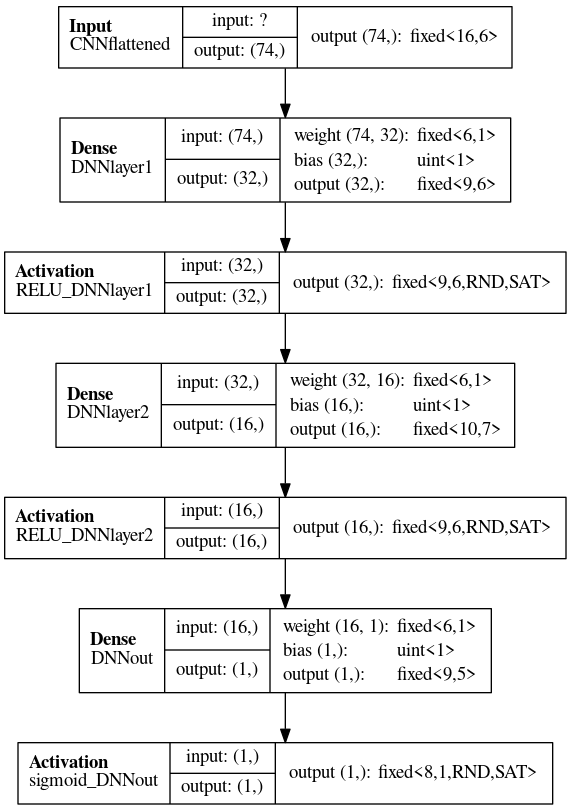

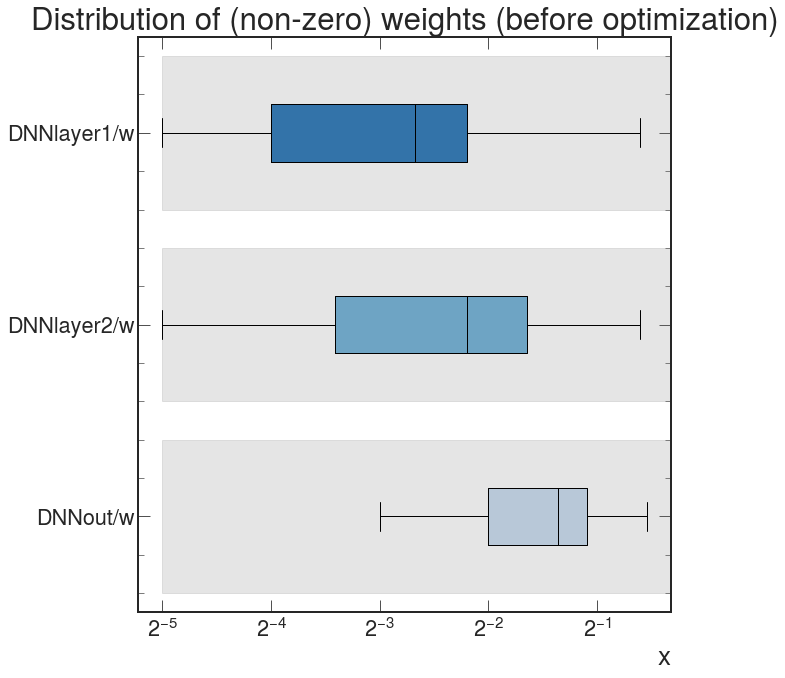

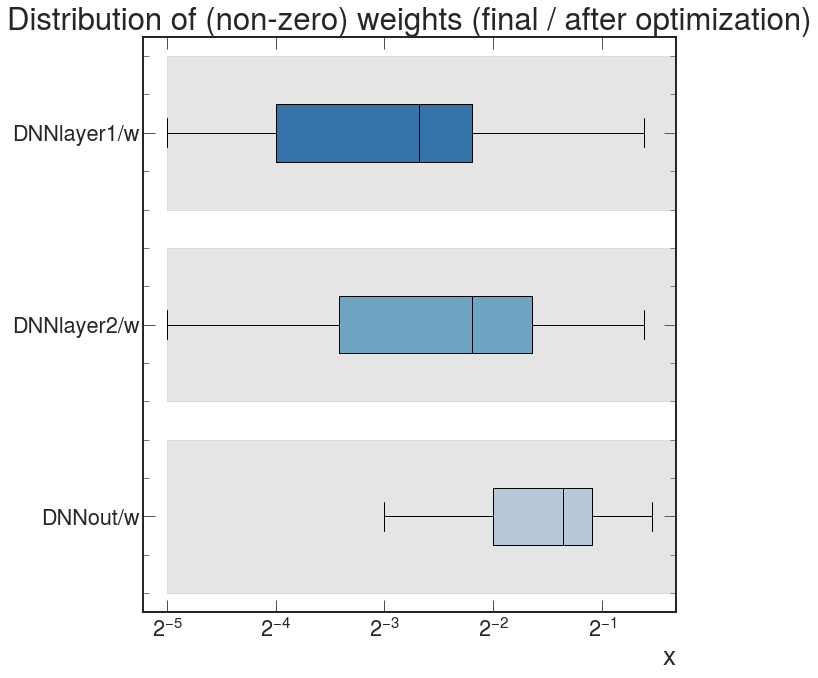

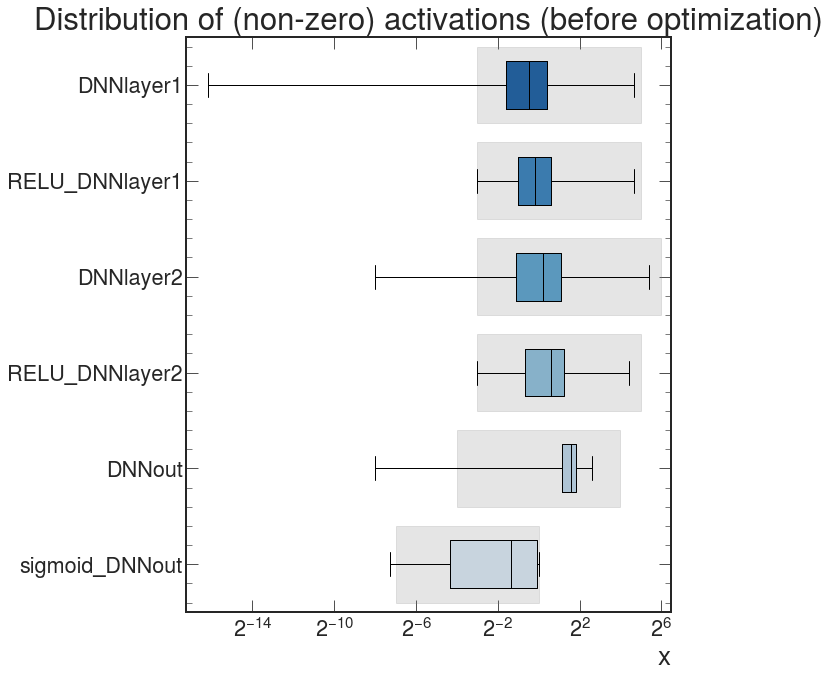

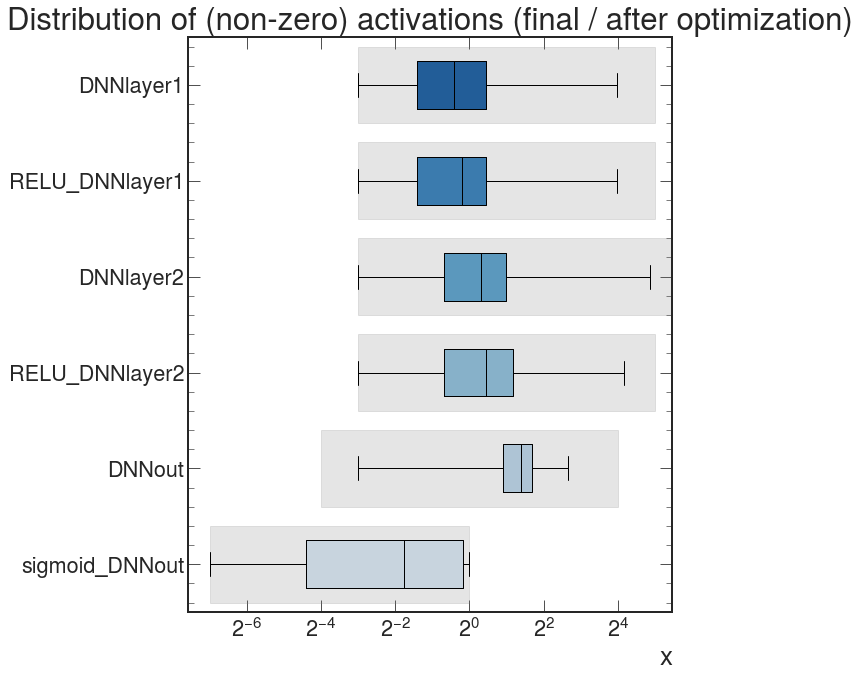

In [11]:
############################## Pass quantized identification DNN model through hls4ml ##############################

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=['Activation'],
                                                                                  rounding_mode='AP_RND',
                                                                                  saturation_mode='AP_SAT')

# baseline model
id_QDNN_hls_cfg = hls4ml.utils.config_from_keras_model(QDNNident, granularity='name')
id_QDNN_hls_cfg['Model']['Precision'] = 'ap_fixed<16,6>'
id_QDNN_hls_cfg['Model']['ReuseFactor'] = 1
for Layer in id_QDNN_hls_cfg['LayerName'].keys():
    id_QDNN_hls_cfg['LayerName'][Layer]['Strategy'] = 'Latency'
    id_QDNN_hls_cfg['LayerName'][Layer]['ReuseFactor'] = 1
    id_QDNN_hls_cfg['LayerName'][Layer]['Trace'] = True
#     id_QDNN_hls_cfg['LayerName'][Layer]['Precision'] = 'ap_fixed<16,7>'

id_QDNN_hls_cfg['LayerName']['DNNlayer1']['Precision']['weight'] = 'ap_fixed<6,1>'
id_QDNN_hls_cfg['LayerName']['DNNlayer1']['Precision']['result'] = 'ap_fixed<9,6>'
id_QDNN_hls_cfg['LayerName']['DNNlayer1']['Precision']['accum'] = 'ap_fixed<13,5>'
id_QDNN_hls_cfg['LayerName']['RELU_DNNlayer1']['Precision'] = 'ap_fixed<9,6>'

id_QDNN_hls_cfg['LayerName']['DNNlayer2']['Precision']['weight'] = 'ap_fixed<6,1>'
id_QDNN_hls_cfg['LayerName']['DNNlayer2']['Precision']['result'] = 'ap_fixed<10,7>'
id_QDNN_hls_cfg['LayerName']['DNNlayer2']['Precision']['accum'] = 'ap_fixed<11,6>'
id_QDNN_hls_cfg['LayerName']['RELU_DNNlayer2']['Precision'] = 'ap_fixed<9,6>'

id_QDNN_hls_cfg['LayerName']['DNNout']['Precision']['weight'] = 'ap_fixed<6,1>'
id_QDNN_hls_cfg['LayerName']['DNNout']['Precision']['result'] = 'ap_fixed<9,5>'
id_QDNN_hls_cfg['LayerName']['DNNout']['Precision']['accum'] = 'ap_fixed<7,4>'

id_QDNN_hls_cfg['LayerName']['sigmoid_DNNout']['Precision'] = 'ap_fixed<8,1>'
id_QDNN_hls_cfg['LayerName']['sigmoid_DNNout']['Strategy'] = 'Stable'

print(id_QDNN_hls_cfg)

id_QDNN_cfg = hls4ml.converters.create_config(backend='Vivado')
id_QDNN_cfg['IOType']     = 'io_parallel'
id_QDNN_cfg['HLSConfig']  = id_QDNN_hls_cfg
id_QDNN_cfg['KerasModel'] = QDNNident
id_QDNN_cfg['OutputDir']  = identdir+'/QDNNmodel_HLS/'
id_QDNN_cfg['Part']       = 'xcvu13p-fhgb2104-2L-e'
id_QDNN_cfg['XilinxPart'] = 'xcvu13p-fhgb2104-2L-e'

QDNNident_hls = hls4ml.converters.keras_to_hls(id_QDNN_cfg)

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=[])
QDNNident_hls.compile()

id_QCNNoutput = np.array(QCNN([X1_id_reduced,X2_id_reduced]))

hls4ml.model.profiling.numerical(model=QDNNident, hls_model=QDNNident_hls, X=id_QCNNoutput)
hls4ml.utils.plot_model(QDNNident_hls, show_shapes=True, show_precision=True, to_file=None)

## Create HLS model for the calibration DNN - QUANTIZED

Interpreting Model
Topology:
Layer name: CNNflattened, layer type: Input
Layer name: DNNlayer1, layer type: QDense
  -> Activation (linear), layer name: DNNlayer1
Layer name: RELU_DNNlayer1, layer type: QActivation
  -> Activation (quantized_relu(9,6)), layer name: RELU_DNNlayer1
Layer name: DNNlayer2, layer type: QDense
  -> Activation (linear), layer name: DNNlayer2
Layer name: RELU_DNNlayer2, layer type: QActivation
  -> Activation (quantized_relu(9,6)), layer name: RELU_DNNlayer2
Layer name: DNNout, layer type: QDense
  -> Activation (linear), layer name: DNNout
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'CNNflattened': {'Precision': 'ap_fixed<16,7>', 'Strategy': 'Resources', 'ReuseFactor': 1, 'Trace': True}, 'DNNlayer1': {'Precision': {'weight': 'ap_fixed<6,2>', 'result': 'ap_fixed<20,7>', 'accum': 'ap_fixed<16,5>'}, 'ReuseFactor': 1, 'Strategy': 'Resources', 'Trace': True}, 'DNNlayer1_linear': {'Precision': 'ap_fixed<16,6>', 

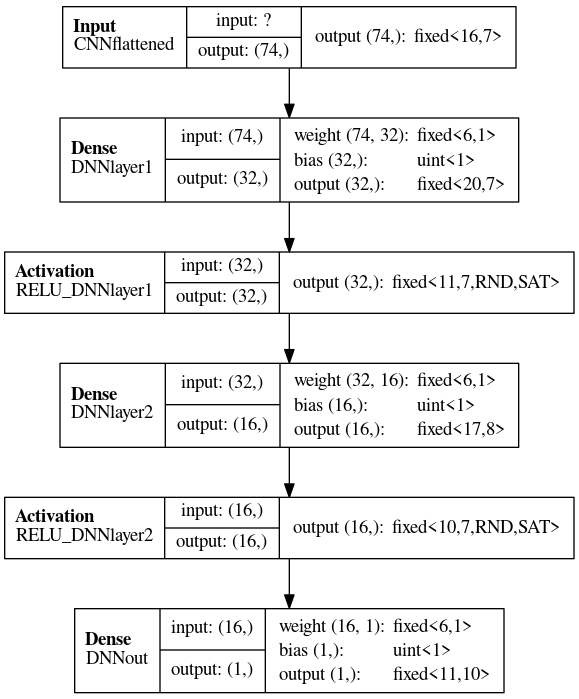

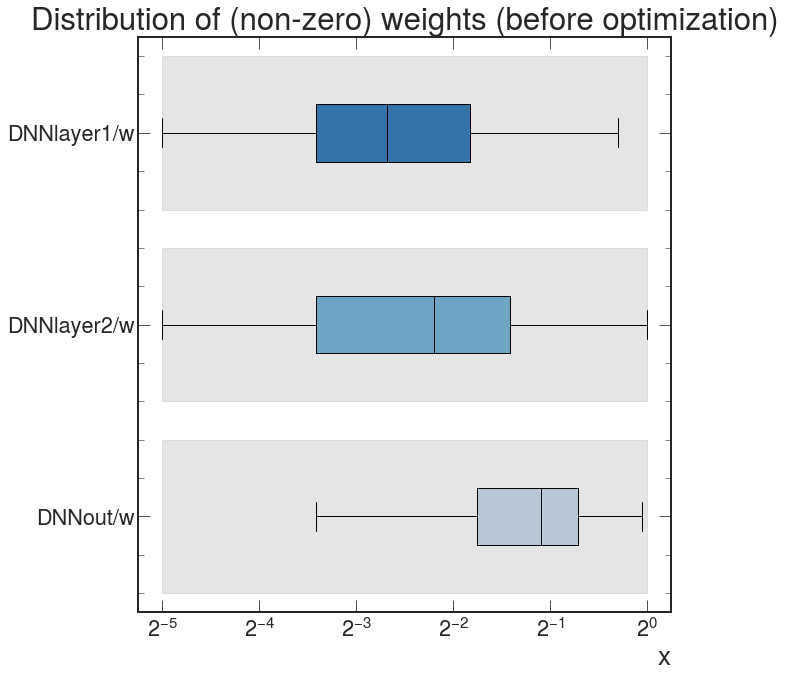

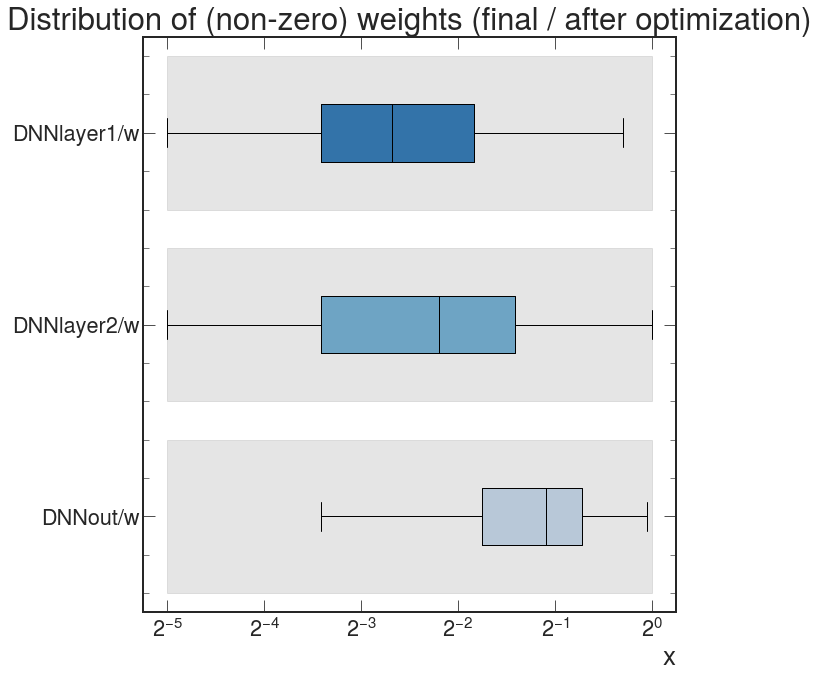

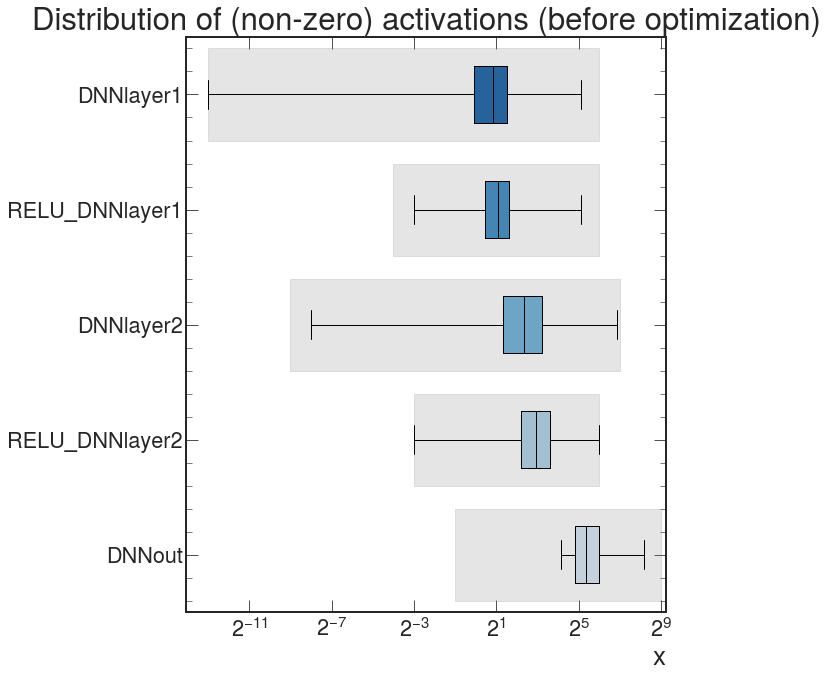

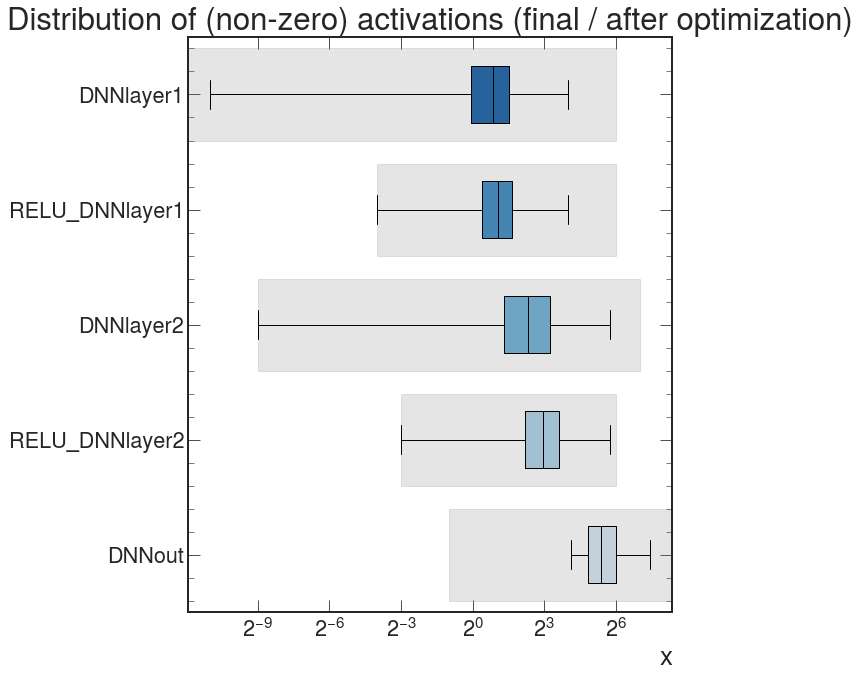

In [12]:
############################## Pass quantized calibration DNN model through hls4ml ##############################

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=['Activation'],
                                                                                  rounding_mode='AP_RND',
                                                                                  saturation_mode='AP_SAT')

# baseline model
cal_QDNN_hls_cfg = hls4ml.utils.config_from_keras_model(QDNNcalib, granularity='name')
cal_QDNN_hls_cfg['Model']['Precision'] = 'ap_fixed<16,6>'
cal_QDNN_hls_cfg['Model']['ReuseFactor'] = 1
for Layer in cal_QDNN_hls_cfg['LayerName'].keys():
    cal_QDNN_hls_cfg['LayerName'][Layer]['Strategy'] = 'Resources'
    cal_QDNN_hls_cfg['LayerName'][Layer]['ReuseFactor'] = 1
    cal_QDNN_hls_cfg['LayerName'][Layer]['Trace'] = True

cal_QDNN_hls_cfg['LayerName']['CNNflattened']['Precision'] = 'ap_fixed<16,7>'
    
cal_QDNN_hls_cfg['LayerName']['DNNlayer1']['Precision']['weight'] = 'ap_fixed<6,2>'
cal_QDNN_hls_cfg['LayerName']['DNNlayer1']['Precision']['result'] = 'ap_fixed<20,7>'
cal_QDNN_hls_cfg['LayerName']['DNNlayer1']['Precision']['accum'] = 'ap_fixed<16,5>'
cal_QDNN_hls_cfg['LayerName']['RELU_DNNlayer1']['Precision'] = 'ap_fixed<11,7>'

cal_QDNN_hls_cfg['LayerName']['DNNlayer2']['Precision']['weight'] = 'ap_fixed<6,2>'
cal_QDNN_hls_cfg['LayerName']['DNNlayer2']['Precision']['result'] = 'ap_fixed<17,8>'
cal_QDNN_hls_cfg['LayerName']['DNNlayer2']['Precision']['accum'] = 'ap_fixed<16,7>'
cal_QDNN_hls_cfg['LayerName']['RELU_DNNlayer2']['Precision'] = 'ap_fixed<10,7>'

cal_QDNN_hls_cfg['LayerName']['DNNout']['Precision']['weight'] = 'ap_fixed<6,1>'
cal_QDNN_hls_cfg['LayerName']['DNNout']['Precision']['result'] = 'ap_fixed<11,10>'
cal_QDNN_hls_cfg['LayerName']['DNNout']['Precision']['accum'] = 'ap_fixed<16,9>'
cal_QDNN_hls_cfg['LayerName']['DNNout']['Strategy'] = 'Stable'

print(cal_QDNN_hls_cfg)

cal_QDNN_cfg = hls4ml.converters.create_config(backend='Vivado')
cal_QDNN_cfg['IOType']     = 'io_stream'
cal_QDNN_cfg['HLSConfig']  = cal_QDNN_hls_cfg
cal_QDNN_cfg['KerasModel'] = QDNNcalib
cal_QDNN_cfg['OutputDir']  = calibdir+'/QDNNmodel_HLS/'
cal_QDNN_cfg['Part']       = 'xcvu13p-fhgb2104-2L-e'
cal_QDNN_cfg['XilinxPart'] = 'xcvu13p-fhgb2104-2L-e'

QDNNcalib_hls = hls4ml.converters.keras_to_hls(cal_QDNN_cfg)

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=[])
QDNNcalib_hls.compile()

cal_QCNNoutput = np.array(QCNN([X1_cal_reduced,X2_cal_reduced]))

hls4ml.model.profiling.numerical(model=QDNNcalib, hls_model=QDNNcalib_hls, X=cal_QCNNoutput)
hls4ml.utils.plot_model(QDNNcalib_hls, show_shapes=True, show_precision=True, to_file=None)

# COMPARE HLS TO KERAS AND QKERAS MODELS

In [13]:
def plotROC(Y, y_pred, y_pred_hls4ml, label="Model"):
    
    accuracy_keras  = float(accuracy_score(np.argmax(Y,axis=1), np.argmax(y_pred,axis=1), normalize=True))
    accuracy_hls4ml = float(accuracy_score(np.argmax(Y,axis=1), np.argmax(y_pred_hls4ml,axis=1), normalize=True))

    print("Accuracy Keras:  {}".format(accuracy_keras))
    print("Accuracy hls4ml: {}".format(accuracy_hls4ml))
    
    fig, ax = plt.subplots(figsize=(10, 10))

    FPR, TPR, THR = metrics.roc_curve(Y, y_pred)
    AUC = metrics.roc_auc_score(Y, y_pred)
    
    FPR_HLS, TPR_HLS, THR_HLS = metrics.roc_curve(Y, y_pred_hls4ml)
    AUC_HLS = metrics.roc_auc_score(Y, y_pred_hls4ml)
    
    plt.plot(TPR, FPR, label=label+' ROC, AUC = %.3f' % (AUC),   color='blue',lw=2)
    plt.plot(TPR_HLS, FPR_HLS, label='HLS ROC, AUC = %.3f' % (AUC_HLS), color='green',lw=2)
    
    plt.legend(loc = 'upper left', fontsize=16)
    plt.xlabel('Signal Efficiency')
    plt.ylabel('Background Efficiency')
    mplhep.cms.label('Phase-2 Simulation', data=True, rlabel='14 TeV, 200 PU')
    plt.ylim(0.01,1.)
    plt.xlim(0.7,1.)

In [14]:
# non-quantized models ID
y_ident        = DNNident.predict(CNN.predict([X1_id, X2_id]))
y_ident_hls4ml = DNNident_hls.predict(CNN_hls.predict([X1_id, X2_id]))

In [15]:
# quantized models ID
y_ident_q        = QDNNident.predict(QCNN.predict([X1_id, X2_id]))
y_ident_hls4ml_q = QDNNident_hls.predict(QCNN_hls.predict([X1_id, X2_id]))

In [16]:
# non-quantized models CALIB
y_calib        = DNNcalib.predict(CNN.predict([X1_cal, X2_cal]))
y_calib_hls4ml = DNNcalib_hls.predict(CNN_hls.predict([X1_cal, X2_cal]))

In [17]:
# quantized models CALIB
y_calib_q        = QDNNcalib.predict(QCNN.predict([X1_cal, X2_cal]))
y_calib_hls4ml_q = QDNNcalib_hls.predict(QCNN_hls.predict([X1_cal, X2_cal]))

Accuracy Keras:  1.0
Accuracy hls4ml: 1.0
Accuracy Keras:  1.0
Accuracy hls4ml: 1.0


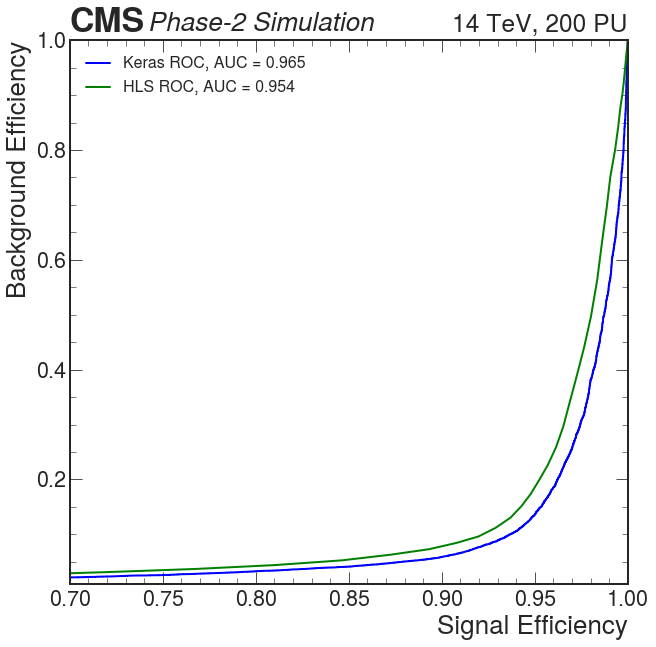

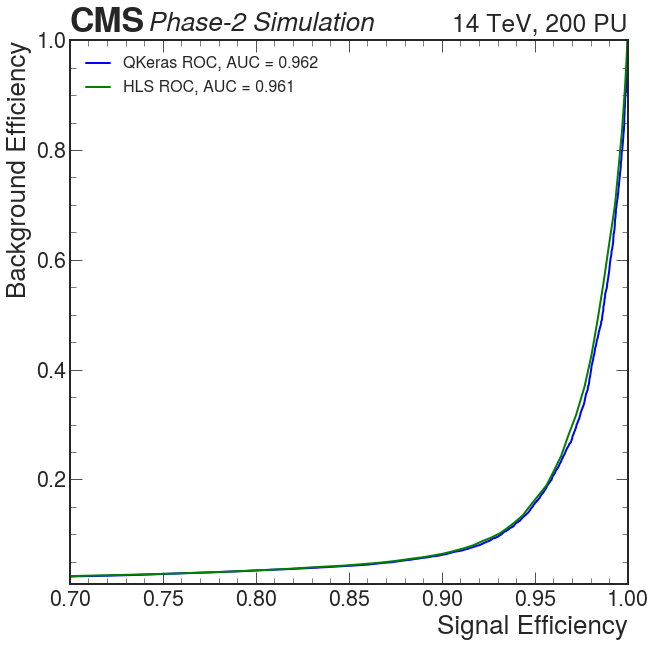

In [18]:
# Plot the floating point model:    
plotROC(Y_id,y_ident,y_ident_hls4ml,label="Keras") 

# Plot the quantized QKeras model
plotROC(Y_id,y_ident_q,y_ident_hls4ml_q,label="QKeras") 

In [19]:
gen = Y_cal[:,0]

response_base = y_calib.ravel() / gen
response_hls4ml = y_calib_hls4ml.ravel() / gen
response_q = y_calib_q.ravel() / gen
response_q_hls4ml = y_calib_hls4ml_q.ravel() / gen

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Phase-2 Simulation'))

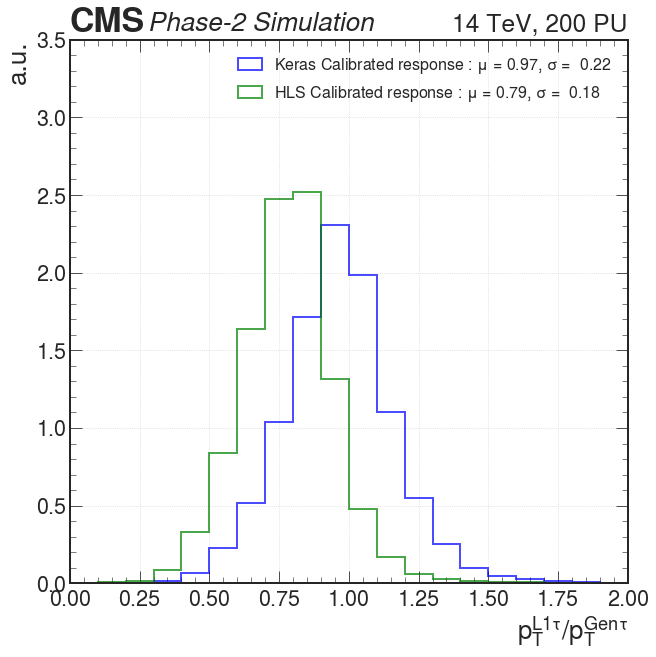

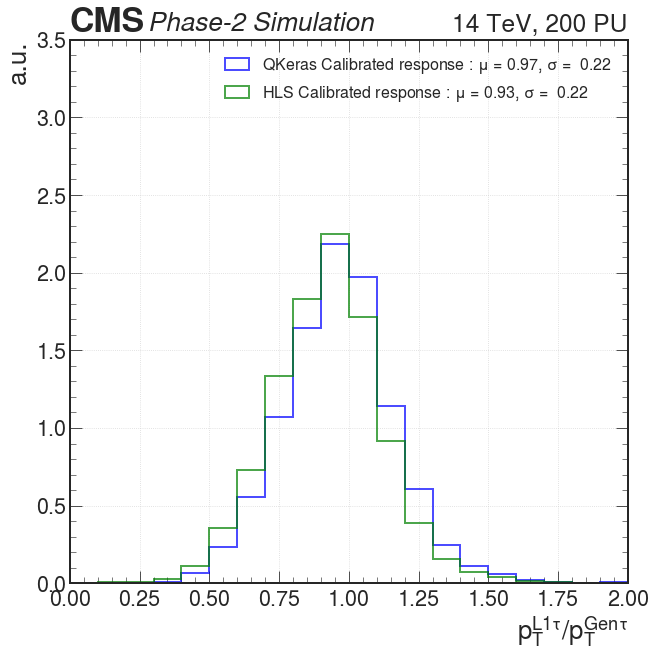

In [20]:
plt.figure(figsize=(10,10))
plt.hist(response_base,     bins=np.arange(0,5,0.1), label=r'Keras Calibrated response : $\mu$ = %.2f, $\sigma$ =  %.2f' % (np.mean(response_base), np.std(response_base)), color='blue', lw=2, density=True, histtype='step', alpha=0.7)
plt.hist(response_hls4ml,   bins=np.arange(0,5,0.1), label=r'HLS Calibrated response : $\mu$ = %.2f, $\sigma$ =  %.2f' % (np.mean(response_hls4ml), np.std(response_hls4ml)), color='green',lw=2, density=True, histtype='step', alpha=0.7)
plt.xlabel(r'$p_{T}^{L1 \tau} / p_{T}^{Gen \tau}$')
plt.ylabel(r'a.u.')
plt.xlim(0., 2.)
plt.ylim(0., 3.5)
plt.legend(loc = 'upper right', fontsize=16)
plt.grid(linestyle='dotted')
mplhep.cms.label('Phase-2 Simulation', data=True, rlabel='14 TeV, 200 PU')

plt.figure(figsize=(10,10))
plt.hist(response_q,        bins=np.arange(0,5,0.1), label=r'QKeras Calibrated response : $\mu$ = %.2f, $\sigma$ =  %.2f' % (np.mean(response_q), np.std(response_q)), color='blue', lw=2, density=True, histtype='step', alpha=0.7)
plt.hist(response_q_hls4ml, bins=np.arange(0,5,0.1), label=r'HLS Calibrated response : $\mu$ = %.2f, $\sigma$ =  %.2f' % (np.mean(response_q_hls4ml), np.std(response_q_hls4ml)), color='green', lw=2, density=True, histtype='step', alpha=0.7)
plt.xlabel(r'$p_{T}^{L1 \tau} / p_{T}^{Gen \tau}$')
plt.ylabel(r'a.u.')
plt.xlim(0., 2.)
plt.ylim(0., 3.5)
plt.legend(loc = 'upper right', fontsize=16)
plt.grid(linestyle='dotted')
mplhep.cms.label('Phase-2 Simulation', data=True, rlabel='14 TeV, 200 PU')

In [21]:
# keras = CNN.predict([X1_cal, X2_cal]).ravel()
# hls = CNN_hls.predict([X1_cal, X2_cal]).ravel()

In [22]:
# plt.figure(figsize=(10,10))
# plt.hist(keras,      bins=np.arange(-4,34,0.1), label=r'Keras Calibrated response : $\mu$ = %.2f, $\sigma$ =  %.2f' % (np.mean(keras), np.std(keras)), color='blue', lw=2, density=True, histtype='step', alpha=0.7)
# plt.hist(hls,    bins=np.arange(-4,34,0.1), label=r'HLS Calibrated response : $\mu$ = %.2f, $\sigma$ =  %.2f' % (np.mean(hls), np.std(hls)), color='green',lw=2, density=True, histtype='step', alpha=0.7)
# plt.xlabel(r'$p_{T}^{L1 \tau} / p_{T}^{Gen \tau}$')
# plt.ylabel(r'a.u.')
# # plt.xlim(-0.2, 3.)
# # plt.ylim(0., 3.5)
# plt.yscale('log')
# # plt.xscale('semilog')
# plt.legend(loc = 'upper right', fontsize=16)
# plt.grid(linestyle='dotted')
# mplhep.cms.label('Phase-2 Simulation', data=True, rlabel='14 TeV, 200 PU')

# SYNTHESISE MODELS WITH VIVADO

In [23]:
synth = True
if synth:
    os.environ['PATH'] = '/home/llr/cms/motta/Xilinx/Vivado/2019.2/bin:' + os.environ['PATH']
    CNN_hls.build(csim=False, synth=True, vsynth=True)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.2 (64-bit)
  **** SW Build 2708876 on Wed Nov  6 21:39:14 MST 2019
  **** IP Build 2700528 on Thu Nov  7 00:09:20 MST 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /home/llr/cms/motta/Xilinx/Vivado/2019.2/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/home/llr/cms/motta/Xilinx/Vivado/2019.2/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'motta' on host 'llrai01.in2p3.fr' (Linux_x86_64 version 3.10.0-1160.49.1.el7.x86_64) on Tue Sep 27 12:34:34 CEST 2022
INFO: [HLS 200-10] On os "CentOS Linux release 7.9.2009 (Core)"
INFO: [HLS 200-10] In directory '/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNIdentifier5x9Training_lTauPtCut18/CNNmodel_HLS'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Creating and opening project '/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09

INFO: [HLS 200-111] Finished Checking Synthesizability Time (s): cpu = 00:00:25 ; elapsed = 00:00:31 . Memory (MB): peak = 1117.621 ; gain = 595.531 ; free physical = 305049 ; free virtual = 375751
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::concatenate1d<ap_fixed<19, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<19, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<19, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, config11>' (firmware/nnet_utils/nnet_merge.h:170:44).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::relu<ap_fixed<19, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<19, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, relu_config8>' (firmware/nnet_utils/nnet_activation.h:66:39).
INFO: [XFORM 203-502] Unrolling all sub-loops inside loop 'PartitionLoop' (firmware/nnet_utils/nnet_conv2d_latency.h:196) in function 'nnet::conv_2d_cl<ap_fixed<19, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<19, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>' for pipelining.
I

INFO: [XFORM 203-101] Partitioning array 'data_buf.i'  in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'mult.V' (firmware/nnet_utils/nnet_conv2d_latency.h:183) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'acc.V' (firmware/nnet_utils/nnet_conv2d_latency.h:186) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'w6.V'  in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'b6.V'  in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'pool.V' (firmware/nnet_utils/nnet_pooling.h:228) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'data_buf.i'  in dimension 2 completely.
INFO: [XFORM 203-101] Partitioning array 'data_buf.i'  in dimension 2 completely.
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::mantissa' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEE

INFO: [HLS 200-111] Finished Architecture Synthesis Time (s): cpu = 00:04:35 ; elapsed = 00:04:42 . Memory (MB): peak = 3097.277 ; gain = 2575.188 ; free physical = 303970 ; free virtual = 374684
INFO: [HLS 200-10] Starting hardware synthesis ...
INFO: [HLS 200-10] Synthesizing 'myproject' ...
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'fill_buffer_1' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'fill_buffer.1'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 2.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 282.75 seconds; current allocated memory: 823.529 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource

INFO: [HLS 200-111]  Elapsed time: 19.2 seconds; current allocated memory: 866.009 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Starting global binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 27.61 seconds; current allocated memory: 930.824 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'relu_ap_fixed_ap_fixed_19_7_0_0_0_relu_config4_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'relu<ap_fixed,ap_fixed<19,7,0,0,0>,relu_config4>'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 1.
INFO: [SCHED 204-11] Finishe

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'conv_2d_cl_ap_fixed_ap_fixed_19_7_5_3_0_config2_1892' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-104] Estimated max fanout for 'conv_2d_cl_ap_fixed_ap_fixed_19_7_5_3_0_config2_1892' is 9731 from HDL expression: (1'b1 == ap_CS_fsm_state6)
INFO: [RTGEN 206-100] Finished creating RTL model for 'conv_2d_cl_ap_fixed_ap_fixed_19_7_5_3_0_config2_1892'.
INFO: [HLS 200-111]  Elapsed time: 21.5 seconds; current allocated memory: 1.766 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'relu_ap_fixed_ap_fixed_19_7_0_0_0_relu_config4_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-104] Estimated max fanout for 'relu_ap_fixed_ap_fixed_19_7_0_0_0_relu_config4_s' is 18947 

INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/layer11_out_49_V' to 'ap_vld'.
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/layer11_out_50_V' to 'ap_vld'.
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/layer11_out_51_V' to 'ap_vld'.
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/layer11_out_52_V' to 'ap_vld'.
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/layer11_out_53_V' to 'ap_vld'.
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/layer11_out_54_V' to 'ap_vld'.
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/layer11_out_55_V' to 'ap_vld'.
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/layer11_out_56_V' to 'ap_vld'.
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/layer11_out_57_V' to 'ap_vld'.
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/layer11_out_58_V' to 'ap_vld'.
INFO: [RTGEN 206-500] Setting interface mode on po

INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_59_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_60_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_61_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_62_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_63_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_64_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_65_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_66_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_67_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_68_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implement

INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_147_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_148_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_149_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_150_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_151_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_152_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_153_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_154_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_155_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_156_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_231_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_232_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_233_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_234_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_235_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_236_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_237_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_238_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_239_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_240_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_316_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_317_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_318_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_319_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_320_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_321_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_322_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_323_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_324_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_325_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_403_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_404_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_405_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_406_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_407_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_408_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_409_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_410_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_411_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_412_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_487_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_488_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_489_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_490_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_491_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_492_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_493_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_494_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_495_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_496_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_62_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_63_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_64_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_65_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_66_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_67_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_68_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_69_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_70_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_71_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implement

INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_149_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_150_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_151_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_152_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_153_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_154_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_155_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_156_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_157_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_158_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_236_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_237_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_238_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_239_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_240_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_241_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_242_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_243_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_244_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_245_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_321_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_322_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_323_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_324_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_325_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_326_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_327_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_328_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_329_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_330_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_406_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_407_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_408_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_409_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_410_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_411_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_412_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_413_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_414_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_415_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_492_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_493_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_494_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_495_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_496_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_497_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_498_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_499_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_500_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_501_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_65_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_66_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_67_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_68_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_69_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_70_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_71_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_72_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_73_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_74_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implement

INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_23_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_24_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_25_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_26_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_27_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_28_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_29_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_30_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_31_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_32_V_U(fifo_w19_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implement

INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_36_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_37_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_38_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_39_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_40_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_41_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_42_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_43_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_44_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_45_V_U(fifo_w18_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implement

INFO: [Synth 8-256] done synthesizing module 'relu_ap_fixed_ap_fixed_19_7_0_0_0_relu_config4_s' (3#1) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNIdentifier5x9Training_lTauPtCut18/CNNmodel_HLS/myproject_prj/solution1/syn/vhdl/relu_ap_fixed_ap_fixed_19_7_0_0_0_relu_config4_s.vhd:1048]
INFO: [Synth 8-3491] module 'pooling2d_cl_ap_fixed_ap_fixed_19_7_5_3_0_config5_s' declared at '/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNIdentifier5x9Training_lTauPtCut18/CNNmodel_HLS/myproject_prj/solution1/syn/vhdl/pooling2d_cl_ap_fixed_ap_fixed_19_7_5_3_0_config5_s.vhd:12' bound to instance 'pooling2d_cl_ap_fixed_ap_fixed_19_7_5_3_0_config5_U0' of component 'pooling2d_cl_ap_fixed_ap_fixed_19_7_5_3_0_config5_s' [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNIdentifier5x9Training_lTauPtCut18/CNNmodel_HLS/myproject_prj/solution1/syn/vhdl/myproject.vhd:13888]
INFO: [Synth 8-638] synthesizing module 'pooling2d_cl_ap_fixed_ap_fixed_19_7_

INFO: [Synth 8-256] done synthesizing module 'pooling2d_cl_ap_fixed_ap_fixed_19_7_5_3_0_config5_s' (6#1) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNIdentifier5x9Training_lTauPtCut18/CNNmodel_HLS/myproject_prj/solution1/syn/vhdl/pooling2d_cl_ap_fixed_ap_fixed_19_7_5_3_0_config5_s.vhd:664]
INFO: [Synth 8-638] synthesizing module 'conv_2d_cl_ap_fixed_ap_fixed_19_7_5_3_0_config6_s' [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNIdentifier5x9Training_lTauPtCut18/CNNmodel_HLS/myproject_prj/solution1/syn/vhdl/conv_2d_cl_ap_fixed_ap_fixed_19_7_5_3_0_config6_s.vhd:224]
INFO: [Synth 8-5534] Detected attribute (* fsm_encoding = "none" *) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNIdentifier5x9Training_lTauPtCut18/CNNmodel_HLS/myproject_prj/solution1/syn/vhdl/conv_2d_cl_ap_fixed_ap_fixed_19_7_5_3_0_config6_s.vhd:1211]
INFO: [Synth 8-5534] Detected attribute (* fsm_encoding = "none" *) [/grid_mnt/data__data.polcms/cms/motta/P

	Parameter ID bound to: 1 - type: integer 
	Parameter NUM_STAGE bound to: 1 - type: integer 
	Parameter din0_WIDTH bound to: 1 - type: integer 
	Parameter din1_WIDTH bound to: 1 - type: integer 
	Parameter din2_WIDTH bound to: 1 - type: integer 
	Parameter din3_WIDTH bound to: 1 - type: integer 
	Parameter din4_WIDTH bound to: 1 - type: integer 
	Parameter din5_WIDTH bound to: 1 - type: integer 
	Parameter din6_WIDTH bound to: 1 - type: integer 
	Parameter din7_WIDTH bound to: 1 - type: integer 
	Parameter din8_WIDTH bound to: 1 - type: integer 
	Parameter din9_WIDTH bound to: 1 - type: integer 
	Parameter din10_WIDTH bound to: 1 - type: integer 
	Parameter din11_WIDTH bound to: 1 - type: integer 
	Parameter din12_WIDTH bound to: 1 - type: integer 
	Parameter din13_WIDTH bound to: 1 - type: integer 
	Parameter din14_WIDTH bound to: 1 - type: integer 
	Parameter din15_WIDTH bound to: 1 - type: integer 
	Parameter din16_WIDTH bound to: 1 - type: integer 
	Parameter din17_WIDTH bound to: 

	Parameter ID bound to: 1 - type: integer 
	Parameter NUM_STAGE bound to: 1 - type: integer 
	Parameter din0_WIDTH bound to: 1 - type: integer 
	Parameter din1_WIDTH bound to: 1 - type: integer 
	Parameter din2_WIDTH bound to: 1 - type: integer 
	Parameter din3_WIDTH bound to: 1 - type: integer 
	Parameter din4_WIDTH bound to: 1 - type: integer 
	Parameter din5_WIDTH bound to: 1 - type: integer 
	Parameter din6_WIDTH bound to: 1 - type: integer 
	Parameter din7_WIDTH bound to: 1 - type: integer 
	Parameter din8_WIDTH bound to: 1 - type: integer 
	Parameter din9_WIDTH bound to: 1 - type: integer 
	Parameter din10_WIDTH bound to: 1 - type: integer 
	Parameter din11_WIDTH bound to: 1 - type: integer 
	Parameter din12_WIDTH bound to: 1 - type: integer 
	Parameter din13_WIDTH bound to: 1 - type: integer 
	Parameter din14_WIDTH bound to: 1 - type: integer 
	Parameter din15_WIDTH bound to: 1 - type: integer 
	Parameter din16_WIDTH bound to: 1 - type: integer 
	Parameter din17_WIDTH bound to: 

INFO: [Synth 8-256] done synthesizing module 'myproject_mux_646_19_1_1' (11#1) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNIdentifier5x9Training_lTauPtCut18/CNNmodel_HLS/myproject_prj/solution1/syn/vhdl/myproject_mux_646_19_1_1.vhd:149]
	Parameter ID bound to: 1 - type: integer 
	Parameter NUM_STAGE bound to: 1 - type: integer 
	Parameter din0_WIDTH bound to: 19 - type: integer 
	Parameter din1_WIDTH bound to: 19 - type: integer 
	Parameter din2_WIDTH bound to: 19 - type: integer 
	Parameter din3_WIDTH bound to: 19 - type: integer 
	Parameter din4_WIDTH bound to: 19 - type: integer 
	Parameter din5_WIDTH bound to: 19 - type: integer 
	Parameter din6_WIDTH bound to: 19 - type: integer 
	Parameter din7_WIDTH bound to: 19 - type: integer 
	Parameter din8_WIDTH bound to: 19 - type: integer 
	Parameter din9_WIDTH bound to: 19 - type: integer 
	Parameter din10_WIDTH bound to: 19 - type: integer 
	Parameter din11_WIDTH bound to: 19 - type: integer 
	Parameter din12_WI

	Parameter din114_WIDTH bound to: 19 - type: integer 
	Parameter din115_WIDTH bound to: 19 - type: integer 
	Parameter din116_WIDTH bound to: 19 - type: integer 
	Parameter din117_WIDTH bound to: 19 - type: integer 
	Parameter din118_WIDTH bound to: 19 - type: integer 
	Parameter din119_WIDTH bound to: 19 - type: integer 
	Parameter din120_WIDTH bound to: 19 - type: integer 
	Parameter din121_WIDTH bound to: 19 - type: integer 
	Parameter din122_WIDTH bound to: 19 - type: integer 
	Parameter din123_WIDTH bound to: 19 - type: integer 
	Parameter din124_WIDTH bound to: 19 - type: integer 
	Parameter din125_WIDTH bound to: 19 - type: integer 
	Parameter din126_WIDTH bound to: 19 - type: integer 
	Parameter din127_WIDTH bound to: 19 - type: integer 
	Parameter din128_WIDTH bound to: 7 - type: integer 
	Parameter dout_WIDTH bound to: 19 - type: integer 
	Parameter ID bound to: 1 - type: integer 
	Parameter NUM_STAGE bound to: 1 - type: integer 
	Parameter din0_WIDTH bound to: 19 - type: int

	Parameter ID bound to: 1 - type: integer 
	Parameter NUM_STAGE bound to: 1 - type: integer 
	Parameter din0_WIDTH bound to: 19 - type: integer 
	Parameter din1_WIDTH bound to: 19 - type: integer 
	Parameter din2_WIDTH bound to: 19 - type: integer 
	Parameter din3_WIDTH bound to: 19 - type: integer 
	Parameter din4_WIDTH bound to: 19 - type: integer 
	Parameter din5_WIDTH bound to: 19 - type: integer 
	Parameter din6_WIDTH bound to: 19 - type: integer 
	Parameter din7_WIDTH bound to: 19 - type: integer 
	Parameter din8_WIDTH bound to: 19 - type: integer 
	Parameter din9_WIDTH bound to: 19 - type: integer 
	Parameter din10_WIDTH bound to: 19 - type: integer 
	Parameter din11_WIDTH bound to: 19 - type: integer 
	Parameter din12_WIDTH bound to: 19 - type: integer 
	Parameter din13_WIDTH bound to: 19 - type: integer 
	Parameter din14_WIDTH bound to: 19 - type: integer 
	Parameter din15_WIDTH bound to: 19 - type: integer 
	Parameter din16_WIDTH bound to: 19 - type: integer 
	Parameter din17

INFO: [Synth 8-256] done synthesizing module 'conv_2d_cl_ap_fixed_ap_fixed_19_7_5_3_0_config6_s' (12#1) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNIdentifier5x9Training_lTauPtCut18/CNNmodel_HLS/myproject_prj/solution1/syn/vhdl/conv_2d_cl_ap_fixed_ap_fixed_19_7_5_3_0_config6_s.vhd:224]
INFO: [Synth 8-638] synthesizing module 'relu_ap_fixed_ap_fixed_19_7_0_0_0_relu_config8_s' [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNIdentifier5x9Training_lTauPtCut18/CNNmodel_HLS/myproject_prj/solution1/syn/vhdl/relu_ap_fixed_ap_fixed_19_7_0_0_0_relu_config8_s.vhd:168]
INFO: [Synth 8-5534] Detected attribute (* fsm_encoding = "none" *) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNIdentifier5x9Training_lTauPtCut18/CNNmodel_HLS/myproject_prj/solution1/syn/vhdl/relu_ap_fixed_ap_fixed_19_7_0_0_0_relu_config8_s.vhd:178]
INFO: [Synth 8-5534] Detected attribute (* fsm_encoding = "none" *) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1

INFO: [Synth 8-4490] FSM extraction disabled for register 'ap_CS_fsm_reg' through user attribute
INFO: [Synth 8-4490] FSM extraction disabled for register 'ap_CS_fsm_reg' through user attribute
INFO: [Synth 8-5818] HDL ADVISOR - The operator resource <adder> is shared. To prevent sharing consider applying a KEEP on the output of the operator [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNIdentifier5x9Training_lTauPtCut18/CNNmodel_HLS/myproject_prj/solution1/syn/vhdl/fifo_w38_d6_A.vhd:102]
---------------------------------------------------------------------------------
Finished RTL Optimization Phase 2 : Time (s): cpu = 00:01:45 ; elapsed = 00:01:45 . Memory (MB): peak = 3708.027 ; gain = 2084.664 ; free physical = 292734 ; free virtual = 364130
---------------------------------------------------------------------------------

Report RTL Partitions: 
+------+-----------------------------------------------------------+------------+----------+
|      |RTL Partition 

Hierarchical RTL Component report 
Module myproject 
Detailed RTL Component Info : 
+---XORs : 
	   2 Input      1 Bit         XORs := 2592  
+---Registers : 
	                1 Bit    Registers := 1296  
+---Muxes : 
	   2 Input      1 Bit        Muxes := 5     
Module fill_buffer_1 
Detailed RTL Component Info : 
+---Registers : 
	             2160 Bit    Registers := 1     
	               16 Bit    Registers := 33    
	                1 Bit    Registers := 2     
+---Muxes : 
	   2 Input     16 Bit        Muxes := 24    
	   2 Input      1 Bit        Muxes := 63    
Module conv_2d_cl_ap_fixed_ap_fixed_19_7_5_3_0_config2_1892 
Detailed RTL Component Info : 
+---Adders : 
	   3 Input     26 Bit       Adders := 2     
	   2 Input     26 Bit       Adders := 1     
	   3 Input     25 Bit       Adders := 3     
	   2 Input     25 Bit       Adders := 1     
	   2 Input     24 Bit       Adders := 3     
	   2 Input     23 Bit       Adders := 1     
	   3 Input     23 Bit       Adders := 4 

	               19 Bit    Registers := 2     
+---Muxes : 
	   2 Input     19 Bit        Muxes := 1     
Module fifo_w19_d2_A__549 
Detailed RTL Component Info : 
+---Adders : 
	   2 Input      2 Bit       Adders := 1     
+---Registers : 
	                2 Bit    Registers := 1     
	                1 Bit    Registers := 2     
+---Muxes : 
	   2 Input      1 Bit        Muxes := 3     
Module fifo_w19_d2_A_shiftReg__550 
Detailed RTL Component Info : 
+---Registers : 
	               19 Bit    Registers := 2     
+---Muxes : 
	   2 Input     19 Bit        Muxes := 1     
Module fifo_w19_d2_A__550 
Detailed RTL Component Info : 
+---Adders : 
	   2 Input      2 Bit       Adders := 1     
+---Registers : 
	                2 Bit    Registers := 1     
	                1 Bit    Registers := 2     
+---Muxes : 
	   2 Input      1 Bit        Muxes := 3     
Module fifo_w19_d2_A_shiftReg__551 
Detailed RTL Component Info : 
+---Registers : 
	               19 Bit    Registers := 2     
+---

No constraint files found.
---------------------------------------------------------------------------------
Start Cross Boundary and Area Optimization
---------------------------------------------------------------------------------
INFO: [Synth 8-4471] merging register 'data_buf_i_0_58_reg_8273665_reg[18:0]' into 'data_buf_i_0_58_reg_8273665_reg[18:0]' [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNIdentifier5x9Training_lTauPtCut18/CNNmodel_HLS/myproject_prj/solution1/syn/vhdl/conv_2d_cl_ap_fixed_ap_fixed_19_7_5_3_0_config6_s.vhd:46432]
INFO: [Synth 8-4471] merging register 'data_buf_i_0_43_reg_8273465_reg[18:0]' into 'data_buf_i_0_43_reg_8273465_reg[18:0]' [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNIdentifier5x9Training_lTauPtCut18/CNNmodel_HLS/myproject_prj/solution1/syn/vhdl/conv_2d_cl_ap_fixed_ap_fixed_19_7_5_3_0_config6_s.vhd:46416]
INFO: [Synth 8-4471] merging register 'data_buf_i_0_29_reg_8273268_reg[18:0]' into 'data_buf_i_0_29_

DSP Report: Generating DSP mul_ln1118_429_fu_5671_p2, operation Mode is: A2*(B:0x2db).
DSP Report: register data_buf_i_0_19_reg_8273142_reg is absorbed into DSP mul_ln1118_429_fu_5671_p2.
DSP Report: operator mul_ln1118_429_fu_5671_p2 is absorbed into DSP mul_ln1118_429_fu_5671_p2.
DSP Report: Generating DSP mul_ln1118_1238_fu_5066_p2, operation Mode is: A2*(B:0x3f8d1).
DSP Report: register data_buf_i_0_58_reg_8273665_reg is absorbed into DSP mul_ln1118_1238_fu_5066_p2.
DSP Report: operator mul_ln1118_1238_fu_5066_p2 is absorbed into DSP mul_ln1118_1238_fu_5066_p2.
DSP Report: Generating DSP mul_ln1118_906_fu_5675_p2, operation Mode is: A2*(B:0x2ad).
DSP Report: register data_buf_i_0_42_reg_8273454_reg is absorbed into DSP mul_ln1118_906_fu_5675_p2.
DSP Report: operator mul_ln1118_906_fu_5675_p2 is absorbed into DSP mul_ln1118_906_fu_5675_p2.
DSP Report: Generating DSP mul_ln1118_927_fu_6481_p2, operation Mode is: A2*(B:0x3fdbe).
DSP Report: register data_buf_i_0_43_reg_8273465_reg is 

INFO: [Synth 8-3886] merging instance 'grp_fill_buffer_1_fu_125692/data_V_read_1_reg_5592_reg[2096]' (FD) to 'grp_fill_buffer_1_fu_125692/tmp_130_reg_5639_reg[0]'
INFO: [Synth 8-3886] merging instance 'grp_fill_buffer_1_fu_125692/data_V_read_1_reg_5592_reg[2097]' (FD) to 'grp_fill_buffer_1_fu_125692/tmp_130_reg_5639_reg[1]'
INFO: [Synth 8-3886] merging instance 'grp_fill_buffer_1_fu_125692/data_V_read_1_reg_5592_reg[2098]' (FD) to 'grp_fill_buffer_1_fu_125692/tmp_130_reg_5639_reg[2]'
INFO: [Synth 8-3886] merging instance 'grp_fill_buffer_1_fu_125692/data_V_read_1_reg_5592_reg[2099]' (FD) to 'grp_fill_buffer_1_fu_125692/tmp_130_reg_5639_reg[3]'
INFO: [Synth 8-3886] merging instance 'grp_fill_buffer_1_fu_125692/data_V_read_1_reg_5592_reg[2100]' (FD) to 'grp_fill_buffer_1_fu_125692/tmp_130_reg_5639_reg[4]'
INFO: [Synth 8-3886] merging instance 'grp_fill_buffer_1_fu_125692/data_V_read_1_reg_5592_reg[2101]' (FD) to 'grp_fill_buffer_1_fu_125692/tmp_130_reg_5639_reg[5]'
INFO: [Synth 8-3886] m

---------------------------------------------------------------------------------
Finished Cross Boundary and Area Optimization : Time (s): cpu = 00:03:20 ; elapsed = 00:03:25 . Memory (MB): peak = 3910.355 ; gain = 2286.992 ; free physical = 292038 ; free virtual = 363746
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Start ROM, RAM, DSP and Shift Register Reporting
---------------------------------------------------------------------------------

DSP: Preliminary Mapping	Report (see note below)
+-------------------------------------------------------+------------------+--------+--------+--------+--------+--------+------+------+------+------+-------+------+------+
|Module Name                                            | DSP Mapping      | A Size | B Size | C Size | D Size | P Size | AREG | BREG | CREG | DREG | ADREG | MREG | PREG | 
+-----------------------------------


Report RTL Partitions: 
+------+-----------------------------------------------------------+------------+----------+
|      |RTL Partition                                              |Replication |Instances |
+------+-----------------------------------------------------------+------------+----------+
|1     |conv_2d_cl_ap_fixed_ap_fixed_19_7_5_3_0_config2_1892__GB0  |           1|     13538|
|2     |conv_2d_cl_ap_fixed_ap_fixed_19_7_5_3_0_config2_1892__GB1  |           1|     15406|
|3     |conv_2d_cl_ap_fixed_ap_fixed_19_7_5_3_0_config2_1892__GB2  |           1|      4644|
|4     |conv_2d_cl_ap_fixed_ap_fixed_19_7_5_3_0_config2_1892__GB3  |           1|      4399|
|5     |conv_2d_cl_ap_fixed_ap_fixed_19_7_5_3_0_config2_1892__GB4  |           1|      5770|
|6     |conv_2d_cl_ap_fixed_ap_fixed_19_7_5_3_0_config2_1892__GB5  |           1|      8418|
|7     |conv_2d_cl_ap_fixed_ap_fixed_19_7_5_3_0_config2_1892__GB6  |           1|      8670|
|8     |conv_2d_cl_ap_fixed_ap_fixed_19_7_5_3

INFO: [Synth 8-3333] propagating constant 0 across sequential element (layer5_out_0_V_U/\U_fifo_w19_d2_A_shiftReg/SRL_SIG_reg[1][18] )
INFO: [Synth 8-3333] propagating constant 0 across sequential element (layer5_out_1_V_U/\U_fifo_w19_d2_A_shiftReg/SRL_SIG_reg[1][18] )
INFO: [Synth 8-3333] propagating constant 0 across sequential element (layer5_out_2_V_U/\U_fifo_w19_d2_A_shiftReg/SRL_SIG_reg[1][18] )
INFO: [Synth 8-3333] propagating constant 0 across sequential element (layer5_out_3_V_U/\U_fifo_w19_d2_A_shiftReg/SRL_SIG_reg[1][18] )
INFO: [Synth 8-3333] propagating constant 0 across sequential element (layer5_out_4_V_U/\U_fifo_w19_d2_A_shiftReg/SRL_SIG_reg[1][18] )
INFO: [Synth 8-3333] propagating constant 0 across sequential element (layer5_out_5_V_U/\U_fifo_w19_d2_A_shiftReg/SRL_SIG_reg[1][18] )
INFO: [Synth 8-3333] propagating constant 0 across sequential element (layer5_out_13_V_U/\U_fifo_w19_d2_A_shiftReg/SRL_SIG_reg[1][18] )
INFO: [Synth 8-3333] propagating constant 0 across seq

---------------------------------------------------------------------------------
Start IO Insertion
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Start Flattening Before IO Insertion
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished Flattening Before IO Insertion
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Start Final Netlist Cleanup
---------------------------------------------------------------------------------
INFO: [Synth 8-6064] Net \conv_2d_cl_ap_fixed_ap_fixed_19_7_5_3_0_config6_U0/call_ret_fill_buffer_fu_8198504_ap_return_35 [18] is driving 228 big block pins (URAM, BRAM and DSP loads). Created 23 replicas of its driver. 

INFO: [Synth 8-6064] Net \conv_2d_cl_ap_fixed_ap_fixed_19_7_5_3_0_config2_1892_U0/grp_fill_buffer_1_fu_125692_ap_return_10 [15] is driving 180 big block pins (URAM, BRAM and DSP loads). Created 18 replicas of its driver. 
INFO: [Synth 8-6064] Net \conv_2d_cl_ap_fixed_ap_fixed_19_7_5_3_0_config2_1892_U0/grp_fill_buffer_1_fu_125692_ap_return_8 [15] is driving 105 big block pins (URAM, BRAM and DSP loads). Created 11 replicas of its driver. 
INFO: [Synth 8-6064] Net \conv_2d_cl_ap_fixed_ap_fixed_19_7_5_3_0_config2_1892_U0/grp_fill_buffer_1_fu_125692_ap_return_5 [15] is driving 105 big block pins (URAM, BRAM and DSP loads). Created 11 replicas of its driver. 
INFO: [Synth 8-6064] Net \conv_2d_cl_ap_fixed_ap_fixed_19_7_5_3_0_config2_1892_U0/grp_fill_buffer_1_fu_125692_ap_return_3 [15] is driving 105 big block pins (URAM, BRAM and DSP loads). Created 11 replicas of its driver. 
INFO: [Synth 8-6064] Net \conv_2d_cl_ap_fixed_ap_fixed_19_7_5_3_0_config2_1892_U0/grp_fill_buffer_1_fu_125692_ap_re

Synthesis Optimization Runtime : Time (s): cpu = 00:05:26 ; elapsed = 00:05:47 . Memory (MB): peak = 4069.223 ; gain = 2445.859 ; free physical = 298198 ; free virtual = 370221
Synthesis Optimization Complete : Time (s): cpu = 00:05:26 ; elapsed = 00:05:47 . Memory (MB): peak = 4069.223 ; gain = 2445.859 ; free physical = 298217 ; free virtual = 370220
INFO: [Project 1-571] Translating synthesized netlist
Netlist sorting complete. Time (s): cpu = 00:00:03 ; elapsed = 00:00:03 . Memory (MB): peak = 4069.223 ; gain = 0.000 ; free physical = 297971 ; free virtual = 369974
INFO: [Netlist 29-17] Analyzing 9657 Unisim elements for replacement
INFO: [Netlist 29-28] Unisim Transformation completed in 10 CPU seconds
INFO: [Project 1-570] Preparing netlist for logic optimization
INFO: [Opt 31-138] Pushed 0 inverter(s) to 0 load pin(s).
Netlist sorting complete. Time (s): cpu = 00:00:00.03 ; elapsed = 00:00:00.03 . Memory (MB): peak = 4334.031 ; gain = 0.000 ; free physical = 297519 ; free virtua

In [24]:
synth = True
if synth:
    os.environ['PATH'] = '/home/llr/cms/motta/Xilinx/Vivado/2019.2/bin:' + os.environ['PATH']
    QCNN_hls.build(csim=False, synth=True, vsynth=True)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.2 (64-bit)
  **** SW Build 2708876 on Wed Nov  6 21:39:14 MST 2019
  **** IP Build 2700528 on Thu Nov  7 00:09:20 MST 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /home/llr/cms/motta/Xilinx/Vivado/2019.2/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/home/llr/cms/motta/Xilinx/Vivado/2019.2/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'motta' on host 'llrai01.in2p3.fr' (Linux_x86_64 version 3.10.0-1160.49.1.el7.x86_64) on Tue Sep 27 12:56:57 CEST 2022
INFO: [HLS 200-10] On os "CentOS Linux release 7.9.2009 (Core)"
INFO: [HLS 200-10] In directory '/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNIdentifier5x9Training_lTauPtCut18/QCNNmodel_HLS'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Creating and opening project '/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_0

INFO: [HLS 200-111] Finished Checking Synthesizability Time (s): cpu = 00:00:25 ; elapsed = 00:00:28 . Memory (MB): peak = 1119.492 ; gain = 597.402 ; free physical = 304406 ; free virtual = 375761
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::concatenate1d<ap_fixed<16, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, config9>' (firmware/nnet_utils/nnet_merge.h:170:44).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::relu<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, relu_config6>' (firmware/nnet_utils/nnet_activation.h:66:39).
INFO: [XFORM 203-502] Unrolling all sub-loops inside loop 'PartitionLoop' (firmware/nnet_utils/nnet_conv2d_latency.h:196) in function 'nnet::conv_2d_cl<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>' for pipelining.
IN

INFO: [XFORM 203-101] Partitioning array 'data_buf.i'  in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'mult.V' (firmware/nnet_utils/nnet_conv2d_latency.h:183) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'acc.V' (firmware/nnet_utils/nnet_conv2d_latency.h:186) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'w5.V'  in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'b5.V'  in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'pool.V' (firmware/nnet_utils/nnet_pooling.h:228) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'data_buf.i'  in dimension 2 completely.
INFO: [XFORM 203-101] Partitioning array 'data_buf.i'  in dimension 2 completely.
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::mantissa' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEE

INFO: [HLS 200-111] Finished Architecture Synthesis Time (s): cpu = 00:03:23 ; elapsed = 00:03:28 . Memory (MB): peak = 3105.277 ; gain = 2583.188 ; free physical = 303287 ; free virtual = 374653
INFO: [HLS 200-10] Starting hardware synthesis ...
INFO: [HLS 200-10] Synthesizing 'myproject' ...
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'fill_buffer_1' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'fill_buffer.1'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 2.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 208.21 seconds; current allocated memory: 788.518 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'relu_ap_fixed_ap_fixed_16_7_0_0_0_relu_config6_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'relu<ap_fixed,ap_fixed<16,7,0,0,0>,relu_config6>'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 1.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 9.53 seconds; current allocated memory: 983.132 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.67 seconds; current allocated memory: 984.644 MB.
INFO: [HLS 200-10] -----------------

INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/layer9_out_52_V' to 'ap_vld'.
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/layer9_out_53_V' to 'ap_vld'.
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/layer9_out_54_V' to 'ap_vld'.
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/layer9_out_55_V' to 'ap_vld'.
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/layer9_out_56_V' to 'ap_vld'.
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/layer9_out_57_V' to 'ap_vld'.
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/layer9_out_58_V' to 'ap_vld'.
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/layer9_out_59_V' to 'ap_vld'.
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/layer9_out_60_V' to 'ap_vld'.
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/layer9_out_61_V' to 'ap_vld'.
INFO: [RTGEN 206-500] Setting interface mode on port 'myproj

INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_63_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_64_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_65_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_66_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_67_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_68_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_69_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_70_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_71_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_72_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implement

INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_151_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_152_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_153_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_154_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_155_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_156_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_157_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_158_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_159_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_160_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_235_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_236_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_237_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_238_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_239_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_240_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_241_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_242_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_243_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_244_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_324_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_325_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_326_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_327_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_328_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_329_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_330_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_331_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_332_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_333_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_412_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_413_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_414_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_415_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_416_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_417_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_418_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_419_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_420_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_421_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_498_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_499_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_500_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_501_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_502_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_503_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_504_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_505_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_506_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_507_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_72_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_73_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_74_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_75_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_76_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_77_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_78_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_79_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_80_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_81_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implement

INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_158_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_159_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_160_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_161_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_162_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_163_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_164_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_165_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_166_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_167_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_242_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_243_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_244_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_245_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_246_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_247_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_248_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_249_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_250_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_251_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_328_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_329_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_330_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_331_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_332_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_333_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_334_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_335_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_336_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_337_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_413_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_414_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_415_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_416_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_417_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_418_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_419_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_420_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_421_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_422_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_499_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_500_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_501_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_502_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_503_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_504_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_505_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_506_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_507_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_508_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_72_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_73_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_74_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_75_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_76_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_77_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_78_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_79_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_80_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_81_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implement

INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_29_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_30_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_31_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_32_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_33_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_34_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_35_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_36_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_37_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_38_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implement

INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_43_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_44_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_45_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_46_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_47_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_48_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_49_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_50_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_51_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_52_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implement

INFO: [Synth 8-256] done synthesizing module 'relu_ap_fixed_ap_fixed_16_7_0_0_0_relu_config3_s' (3#1) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNIdentifier5x9Training_lTauPtCut18/QCNNmodel_HLS/myproject_prj/solution1/syn/vhdl/relu_ap_fixed_ap_fixed_16_7_0_0_0_relu_config3_s.vhd:1048]
INFO: [Synth 8-3491] module 'pooling2d_cl_ap_fixed_ap_fixed_16_7_5_3_0_config4_s' declared at '/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNIdentifier5x9Training_lTauPtCut18/QCNNmodel_HLS/myproject_prj/solution1/syn/vhdl/pooling2d_cl_ap_fixed_ap_fixed_16_7_5_3_0_config4_s.vhd:12' bound to instance 'pooling2d_cl_ap_fixed_ap_fixed_16_7_5_3_0_config4_U0' of component 'pooling2d_cl_ap_fixed_ap_fixed_16_7_5_3_0_config4_s' [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNIdentifier5x9Training_lTauPtCut18/QCNNmodel_HLS/myproject_prj/solution1/syn/vhdl/myproject.vhd:13888]
INFO: [Synth 8-638] synthesizing module 'pooling2d_cl_ap_fixed_ap_fixed_16

INFO: [Synth 8-256] done synthesizing module 'pooling2d_cl_ap_fixed_ap_fixed_16_7_5_3_0_config4_s' (6#1) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNIdentifier5x9Training_lTauPtCut18/QCNNmodel_HLS/myproject_prj/solution1/syn/vhdl/pooling2d_cl_ap_fixed_ap_fixed_16_7_5_3_0_config4_s.vhd:664]
INFO: [Synth 8-638] synthesizing module 'conv_2d_cl_ap_fixed_ap_fixed_16_7_5_3_0_config5_s' [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNIdentifier5x9Training_lTauPtCut18/QCNNmodel_HLS/myproject_prj/solution1/syn/vhdl/conv_2d_cl_ap_fixed_ap_fixed_16_7_5_3_0_config5_s.vhd:224]
INFO: [Synth 8-5534] Detected attribute (* fsm_encoding = "none" *) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNIdentifier5x9Training_lTauPtCut18/QCNNmodel_HLS/myproject_prj/solution1/syn/vhdl/conv_2d_cl_ap_fixed_ap_fixed_16_7_5_3_0_config5_s.vhd:291]
INFO: [Synth 8-5534] Detected attribute (* fsm_encoding = "none" *) [/grid_mnt/data__data.polcms/cms/motta

INFO: [Synth 8-256] done synthesizing module 'myproject_mux_1287_1_1_1' (8#1) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNIdentifier5x9Training_lTauPtCut18/QCNNmodel_HLS/myproject_prj/solution1/syn/vhdl/myproject_mux_1287_1_1_1.vhd:277]
	Parameter ID bound to: 1 - type: integer 
	Parameter NUM_STAGE bound to: 1 - type: integer 
	Parameter din0_WIDTH bound to: 1 - type: integer 
	Parameter din1_WIDTH bound to: 1 - type: integer 
	Parameter din2_WIDTH bound to: 1 - type: integer 
	Parameter din3_WIDTH bound to: 1 - type: integer 
	Parameter din4_WIDTH bound to: 1 - type: integer 
	Parameter din5_WIDTH bound to: 1 - type: integer 
	Parameter din6_WIDTH bound to: 1 - type: integer 
	Parameter din7_WIDTH bound to: 1 - type: integer 
	Parameter din8_WIDTH bound to: 1 - type: integer 
	Parameter din9_WIDTH bound to: 1 - type: integer 
	Parameter din10_WIDTH bound to: 1 - type: integer 
	Parameter din11_WIDTH bound to: 1 - type: integer 
	Parameter din12_WIDTH bound to

	Parameter din49_WIDTH bound to: 1 - type: integer 
	Parameter din50_WIDTH bound to: 1 - type: integer 
	Parameter din51_WIDTH bound to: 1 - type: integer 
	Parameter din52_WIDTH bound to: 1 - type: integer 
	Parameter din53_WIDTH bound to: 1 - type: integer 
	Parameter din54_WIDTH bound to: 1 - type: integer 
	Parameter din55_WIDTH bound to: 1 - type: integer 
	Parameter din56_WIDTH bound to: 1 - type: integer 
	Parameter din57_WIDTH bound to: 1 - type: integer 
	Parameter din58_WIDTH bound to: 1 - type: integer 
	Parameter din59_WIDTH bound to: 1 - type: integer 
	Parameter din60_WIDTH bound to: 1 - type: integer 
	Parameter din61_WIDTH bound to: 1 - type: integer 
	Parameter din62_WIDTH bound to: 1 - type: integer 
	Parameter din63_WIDTH bound to: 1 - type: integer 
	Parameter din64_WIDTH bound to: 1 - type: integer 
	Parameter din65_WIDTH bound to: 1 - type: integer 
	Parameter din66_WIDTH bound to: 1 - type: integer 
	Parameter din67_WIDTH bound to: 1 - type: integer 
	Parameter d

INFO: [Synth 8-256] done synthesizing module 'myproject_mux_1287_16_1_1' (9#1) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNIdentifier5x9Training_lTauPtCut18/QCNNmodel_HLS/myproject_prj/solution1/syn/vhdl/myproject_mux_1287_16_1_1.vhd:277]
	Parameter ID bound to: 1 - type: integer 
	Parameter NUM_STAGE bound to: 1 - type: integer 
	Parameter din0_WIDTH bound to: 16 - type: integer 
	Parameter din1_WIDTH bound to: 16 - type: integer 
	Parameter din2_WIDTH bound to: 16 - type: integer 
	Parameter din3_WIDTH bound to: 16 - type: integer 
	Parameter din4_WIDTH bound to: 16 - type: integer 
	Parameter din5_WIDTH bound to: 16 - type: integer 
	Parameter din6_WIDTH bound to: 16 - type: integer 
	Parameter din7_WIDTH bound to: 16 - type: integer 
	Parameter din8_WIDTH bound to: 16 - type: integer 
	Parameter din9_WIDTH bound to: 16 - type: integer 
	Parameter din10_WIDTH bound to: 16 - type: integer 
	Parameter din11_WIDTH bound to: 16 - type: integer 
	Parameter din12_

	Parameter din62_WIDTH bound to: 1 - type: integer 
	Parameter din63_WIDTH bound to: 1 - type: integer 
	Parameter din64_WIDTH bound to: 6 - type: integer 
	Parameter dout_WIDTH bound to: 1 - type: integer 
	Parameter ID bound to: 1 - type: integer 
	Parameter NUM_STAGE bound to: 1 - type: integer 
	Parameter din0_WIDTH bound to: 16 - type: integer 
	Parameter din1_WIDTH bound to: 16 - type: integer 
	Parameter din2_WIDTH bound to: 16 - type: integer 
	Parameter din3_WIDTH bound to: 16 - type: integer 
	Parameter din4_WIDTH bound to: 16 - type: integer 
	Parameter din5_WIDTH bound to: 16 - type: integer 
	Parameter din6_WIDTH bound to: 16 - type: integer 
	Parameter din7_WIDTH bound to: 16 - type: integer 
	Parameter din8_WIDTH bound to: 16 - type: integer 
	Parameter din9_WIDTH bound to: 16 - type: integer 
	Parameter din10_WIDTH bound to: 16 - type: integer 
	Parameter din11_WIDTH bound to: 16 - type: integer 
	Parameter din12_WIDTH bound to: 16 - type: integer 
	Parameter din13_WIDT

	Parameter din49_WIDTH bound to: 16 - type: integer 
	Parameter din50_WIDTH bound to: 16 - type: integer 
	Parameter din51_WIDTH bound to: 16 - type: integer 
	Parameter din52_WIDTH bound to: 16 - type: integer 
	Parameter din53_WIDTH bound to: 16 - type: integer 
	Parameter din54_WIDTH bound to: 16 - type: integer 
	Parameter din55_WIDTH bound to: 16 - type: integer 
	Parameter din56_WIDTH bound to: 16 - type: integer 
	Parameter din57_WIDTH bound to: 16 - type: integer 
	Parameter din58_WIDTH bound to: 16 - type: integer 
	Parameter din59_WIDTH bound to: 16 - type: integer 
	Parameter din60_WIDTH bound to: 16 - type: integer 
	Parameter din61_WIDTH bound to: 16 - type: integer 
	Parameter din62_WIDTH bound to: 16 - type: integer 
	Parameter din63_WIDTH bound to: 16 - type: integer 
	Parameter din64_WIDTH bound to: 16 - type: integer 
	Parameter din65_WIDTH bound to: 16 - type: integer 
	Parameter din66_WIDTH bound to: 16 - type: integer 
	Parameter din67_WIDTH bound to: 16 - type: in

INFO: [Synth 8-256] done synthesizing module 'conv_2d_cl_ap_fixed_ap_fixed_16_7_5_3_0_config5_s' (12#1) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNIdentifier5x9Training_lTauPtCut18/QCNNmodel_HLS/myproject_prj/solution1/syn/vhdl/conv_2d_cl_ap_fixed_ap_fixed_16_7_5_3_0_config5_s.vhd:224]
INFO: [Synth 8-638] synthesizing module 'relu_ap_fixed_ap_fixed_16_7_0_0_0_relu_config6_s' [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNIdentifier5x9Training_lTauPtCut18/QCNNmodel_HLS/myproject_prj/solution1/syn/vhdl/relu_ap_fixed_ap_fixed_16_7_0_0_0_relu_config6_s.vhd:168]
INFO: [Synth 8-5534] Detected attribute (* fsm_encoding = "none" *) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNIdentifier5x9Training_lTauPtCut18/QCNNmodel_HLS/myproject_prj/solution1/syn/vhdl/relu_ap_fixed_ap_fixed_16_7_0_0_0_relu_config6_s.vhd:178]
INFO: [Synth 8-5534] Detected attribute (* fsm_encoding = "none" *) [/grid_mnt/data__data.polcms/cms/motta/Phase

INFO: [Synth 8-4490] FSM extraction disabled for register 'ap_CS_fsm_reg' through user attribute
INFO: [Synth 8-5818] HDL ADVISOR - The operator resource <adder> is shared. To prevent sharing consider applying a KEEP on the output of the operator [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNIdentifier5x9Training_lTauPtCut18/QCNNmodel_HLS/myproject_prj/solution1/syn/vhdl/fifo_w32_d6_A.vhd:102]
---------------------------------------------------------------------------------
Finished RTL Optimization Phase 2 : Time (s): cpu = 00:01:17 ; elapsed = 00:01:13 . Memory (MB): peak = 3222.594 ; gain = 1599.605 ; free physical = 295685 ; free virtual = 367750
---------------------------------------------------------------------------------

Report RTL Partitions: 
+------+----------------------------------------------------------+------------+----------+
|      |RTL Partition                                             |Replication |Instances |
+------+-------------------

Hierarchical RTL Component report 
Module myproject 
Detailed RTL Component Info : 
+---XORs : 
	   2 Input      1 Bit         XORs := 2592  
+---Registers : 
	                1 Bit    Registers := 1296  
+---Muxes : 
	   2 Input      1 Bit        Muxes := 5     
Module fill_buffer_1 
Detailed RTL Component Info : 
+---Registers : 
	             2160 Bit    Registers := 1     
	               16 Bit    Registers := 33    
	                1 Bit    Registers := 2     
+---Muxes : 
	   2 Input     16 Bit        Muxes := 24    
	   2 Input      1 Bit        Muxes := 63    
Module conv_2d_cl_ap_fixed_ap_fixed_16_7_5_3_0_config2_1892 
Detailed RTL Component Info : 
+---Adders : 
	   3 Input     19 Bit       Adders := 38    
	   2 Input     19 Bit       Adders := 6     
	  10 Input     16 Bit       Adders := 3     
	   8 Input     16 Bit       Adders := 3     
	   9 Input     16 Bit       Adders := 7     
	  11 Input     16 Bit       Adders := 1     
	   5 Input     16 Bit       Adders := 1 

	                2 Bit    Registers := 1     
	                1 Bit    Registers := 2     
+---Muxes : 
	   2 Input      1 Bit        Muxes := 3     
Module fifo_w15_d2_A_shiftReg__278 
Detailed RTL Component Info : 
+---Registers : 
	               15 Bit    Registers := 2     
+---Muxes : 
	   2 Input     15 Bit        Muxes := 1     
Module fifo_w15_d2_A__278 
Detailed RTL Component Info : 
+---Adders : 
	   2 Input      2 Bit       Adders := 1     
+---Registers : 
	                2 Bit    Registers := 1     
	                1 Bit    Registers := 2     
+---Muxes : 
	   2 Input      1 Bit        Muxes := 3     
Module fifo_w15_d2_A_shiftReg__279 
Detailed RTL Component Info : 
+---Registers : 
	               15 Bit    Registers := 2     
+---Muxes : 
	   2 Input     15 Bit        Muxes := 1     
Module fifo_w15_d2_A__279 
Detailed RTL Component Info : 
+---Adders : 
	   2 Input      2 Bit       Adders := 1     
+---Registers : 
	                2 Bit    Registers := 1     
	   

No constraint files found.
---------------------------------------------------------------------------------
Start Cross Boundary and Area Optimization
---------------------------------------------------------------------------------
INFO: [Synth 8-3333] propagating constant 1 across sequential element (\ap_CS_fsm_reg[0] )
INFO: [Synth 8-3886] merging instance 'grp_fill_buffer_1_fu_8323/data_V_read_1_reg_5592_reg[2096]' (FD) to 'grp_fill_buffer_1_fu_8323/tmp_130_reg_5639_reg[0]'
INFO: [Synth 8-3886] merging instance 'grp_fill_buffer_1_fu_8323/data_V_read_1_reg_5592_reg[2097]' (FD) to 'grp_fill_buffer_1_fu_8323/tmp_130_reg_5639_reg[1]'
INFO: [Synth 8-3886] merging instance 'grp_fill_buffer_1_fu_8323/data_V_read_1_reg_5592_reg[2098]' (FD) to 'grp_fill_buffer_1_fu_8323/tmp_130_reg_5639_reg[2]'
INFO: [Synth 8-3886] merging instance 'grp_fill_buffer_1_fu_8323/data_V_read_1_reg_5592_reg[2099]' (FD) to 'grp_fill_buffer_1_fu_8323/tmp_130_reg_5639_reg[3]'
INFO: [Synth 8-3886] merging instance '


Report RTL Partitions: 
+------+----------------------------------------------------------+------------+----------+
|      |RTL Partition                                             |Replication |Instances |
+------+----------------------------------------------------------+------------+----------+
|1     |conv_2d_cl_ap_fixed_ap_fixed_16_7_5_3_0_config2_1892__GB0 |           1|     13379|
|2     |conv_2d_cl_ap_fixed_ap_fixed_16_7_5_3_0_config2_1892__GB1 |           1|     11213|
|3     |conv_2d_cl_ap_fixed_ap_fixed_16_7_5_3_0_config2_1892__GB2 |           1|      6649|
|4     |conv_2d_cl_ap_fixed_ap_fixed_16_7_5_3_0_config2_1892__GB3 |           1|      6306|
|5     |conv_2d_cl_ap_fixed_ap_fixed_16_7_5_3_0_config2_1892__GB4 |           1|      8222|
|6     |relu_ap_fixed_ap_fixed_16_7_0_0_0_relu_config3_s__GB0     |           1|     16405|
|7     |relu_ap_fixed_ap_fixed_16_7_0_0_0_relu_config3_s__GB1     |           1|      5362|
|8     |relu_ap_fixed_ap_fixed_16_7_0_0_0_relu_config3_

INFO: [Synth 8-3333] propagating constant 0 across sequential element (layer4_out_117_V_U/\U_fifo_w16_d2_A_shiftReg/SRL_SIG_reg[1][15] )
INFO: [Synth 8-3333] propagating constant 0 across sequential element (layer4_out_116_V_U/\U_fifo_w16_d2_A_shiftReg/SRL_SIG_reg[1][15] )
INFO: [Synth 8-3333] propagating constant 0 across sequential element (layer4_out_115_V_U/\U_fifo_w16_d2_A_shiftReg/SRL_SIG_reg[1][15] )
INFO: [Synth 8-3333] propagating constant 0 across sequential element (layer4_out_114_V_U/\U_fifo_w16_d2_A_shiftReg/SRL_SIG_reg[1][15] )
INFO: [Synth 8-3333] propagating constant 0 across sequential element (layer4_out_112_V_U/\U_fifo_w16_d2_A_shiftReg/SRL_SIG_reg[1][15] )
INFO: [Synth 8-3333] propagating constant 0 across sequential element (layer4_out_111_V_U/\U_fifo_w16_d2_A_shiftReg/SRL_SIG_reg[1][15] )
INFO: [Synth 8-3333] propagating constant 0 across sequential element (layer4_out_110_V_U/\U_fifo_w16_d2_A_shiftReg/SRL_SIG_reg[1][15] )
INFO: [Common 17-14] Message 'Synth 8-333

---------------------------------------------------------------------------------
Start IO Insertion
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Start Flattening Before IO Insertion
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished Flattening Before IO Insertion
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Start Final Netlist Cleanup
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished Final Netlist Cleanup
---------------------------------------------------------------------------------
-------------------------

Synthesis Optimization Runtime : Time (s): cpu = 00:04:14 ; elapsed = 00:04:28 . Memory (MB): peak = 3671.621 ; gain = 2048.633 ; free physical = 298232 ; free virtual = 370776
Synthesis Optimization Complete : Time (s): cpu = 00:04:14 ; elapsed = 00:04:28 . Memory (MB): peak = 3671.621 ; gain = 2048.633 ; free physical = 298249 ; free virtual = 370776
INFO: [Project 1-571] Translating synthesized netlist
Netlist sorting complete. Time (s): cpu = 00:00:02 ; elapsed = 00:00:02 . Memory (MB): peak = 3671.621 ; gain = 0.000 ; free physical = 298119 ; free virtual = 370645
INFO: [Netlist 29-17] Analyzing 6215 Unisim elements for replacement
INFO: [Netlist 29-28] Unisim Transformation completed in 0 CPU seconds
INFO: [Project 1-570] Preparing netlist for logic optimization
INFO: [Opt 31-138] Pushed 0 inverter(s) to 0 load pin(s).
Netlist sorting complete. Time (s): cpu = 00:00:00.03 ; elapsed = 00:00:00.02 . Memory (MB): peak = 3715.738 ; gain = 0.000 ; free physical = 297996 ; free virtual

In [25]:
synth = True
if synth:
    os.environ['PATH'] = '/home/llr/cms/motta/Xilinx/Vivado/2019.2/bin:' + os.environ['PATH']
    DNNident_hls.build(csim=False, synth=True, vsynth=True)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.2 (64-bit)
  **** SW Build 2708876 on Wed Nov  6 21:39:14 MST 2019
  **** IP Build 2700528 on Thu Nov  7 00:09:20 MST 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /home/llr/cms/motta/Xilinx/Vivado/2019.2/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/home/llr/cms/motta/Xilinx/Vivado/2019.2/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'motta' on host 'llrai01.in2p3.fr' (Linux_x86_64 version 3.10.0-1160.49.1.el7.x86_64) on Tue Sep 27 13:14:11 CEST 2022
INFO: [HLS 200-10] On os "CentOS Linux release 7.9.2009 (Core)"
INFO: [HLS 200-10] In directory '/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNIdentifier5x9Training_lTauPtCut18/DNNmodel_HLS'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Creating and opening project '/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09

INFO: [HLS 200-111] Finished Checking Synthesizability Time (s): cpu = 00:00:23 ; elapsed = 00:00:27 . Memory (MB): peak = 1119.152 ; gain = 597.062 ; free physical = 303676 ; free virtual = 375752
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::dense_latency<ap_fixed<8, 5, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<9, 5, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>' (firmware/nnet_utils/nnet_dense_latency.h:34:50).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::relu<ap_fixed<9, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<8, 5, (ap_q_mode)0, (ap_o_mode)0, 0>, relu_config5>' (firmware/nnet_utils/nnet_activation.h:66:26).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::dense_latency<ap_fixed<9, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<9, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>' (firmware/nnet_utils/nnet_dense_latency.h:39:55).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::r

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<8, 5, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<9, 5, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>'(firmware/nnet_utils/nnet_dense_latency.h:48:1) to 'nnet::dense_latency<ap_fixed<8, 5, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<9, 5, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>.0' at call site (firmware/nnet_utils/nnet_dense.h:46->firmware/myproject.cpp:85) by setting 'weights.V' to 'w6.V'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<8, 5, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<9, 5, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>.0'(firmware/nnet_utils/nnet_dense_latency.h:48:1) to 'nnet::dense_latency<ap_fixed<8, 5, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<9, 5, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>.0.0' at call site (firmware/nnet_utils/nnet_dense.h:46->firmware/myproject.cpp:85) by setting 'biases.V' to 'b6.V.0'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<9,

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<9, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<9, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_dense_latency.h:48:27) to 'nnet::dense_latency<ap_fixed<9, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<9, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/nnet_utils/nnet_dense.h:46->firmware/myproject.cpp:71) by setting 'biases[15].V' to 'b4.V.15'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<9, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>'(firmware/nnet_utils/nnet_dense_latency.h:48:27) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<9, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0' by setting 'weights.V' to 'w2.V'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<9, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_dense_latency.h:48:27) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<9, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[20].V' to 'b2.V.20'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<9, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_dense_latency.h:48:27) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<9, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[21].V' to 'b2.V.21'.
INFO: [XFORM 203-622] Instantiating function 'nn

INFO: [HLS 200-111] Finished Architecture Synthesis Time (s): cpu = 00:02:26 ; elapsed = 00:02:32 . Memory (MB): peak = 5466.934 ; gain = 4944.844 ; free physical = 301224 ; free virtual = 373308
INFO: [HLS 200-10] Starting hardware synthesis ...
INFO: [HLS 200-10] Synthesizing 'myproject' ...
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'dense_latency.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 2.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 155.66 seconds; current allocated memory: 429.950 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO

INFO: [RTGEN 206-100] Finished creating RTL model for 'dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s'.
INFO: [HLS 200-111]  Elapsed time: 5.12 seconds; current allocated memory: 519.458 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'relu_ap_fixed_ap_fixed_9_6_0_0_0_relu_config3_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'relu_ap_fixed_ap_fixed_9_6_0_0_0_relu_config3_s'.
INFO: [HLS 200-111]  Elapsed time: 20.08 seconds; current allocated memory: 614.631 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'dense_latenc

---------------------------------------------------------------------------------
Finished Synthesize : Time (s): cpu = 00:00:07 ; elapsed = 00:00:10 . Memory (MB): peak = 1992.219 ; gain = 369.406 ; free physical = 300449 ; free virtual = 372662
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished Constraint Validation : Time (s): cpu = 00:00:08 ; elapsed = 00:00:11 . Memory (MB): peak = 1998.148 ; gain = 375.336 ; free physical = 300463 ; free virtual = 372676
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Start Loading Part and Timing Information
---------------------------------------------------------------------------------
Loading part: xcvu13p-fhgb2104-2L-e
INFO: [Synth 8-6742] Reading net delay rules and data
INFO: [Device 21-403] Loading part 

Part Resources:
DSPs: 12288 (col length:96)
BRAMs: 5376 (col length: RAMB18 384 RAMB36 192)
---------------------------------------------------------------------------------
Finished Part Resource Summary
---------------------------------------------------------------------------------
INFO: [Synth 8-5580] Multithreading enabled for synth_design using a maximum of 4 processes.
---------------------------------------------------------------------------------
Start Cross Boundary and Area Optimization
---------------------------------------------------------------------------------
DSP Report: Generating DSP mul_ln1118_14_fu_1122_p2, operation Mode is: A*(B:0x3ffe9).
DSP Report: operator mul_ln1118_14_fu_1122_p2 is absorbed into DSP mul_ln1118_14_fu_1122_p2.
DSP Report: Generating DSP mul_ln1118_12_fu_2197_p2, operation Mode is: A*(B:0x1b).
DSP Report: operator mul_ln1118_12_fu_2197_p2 is absorbed into DSP mul_ln1118_12_fu_2197_p2.
DSP Report: Generating DSP mul_ln1118_13_fu_2957_p2, ope


Report RTL Partitions: 
+------+--------------------------------------------------------------------+------------+----------+
|      |RTL Partition                                                       |Replication |Instances |
+------+--------------------------------------------------------------------+------------+----------+
|1     |dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s__GB0  |           1|     25862|
|2     |dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s__GB1  |           1|      5518|
|3     |dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s__GB2  |           1|      4558|
|4     |dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s__GB3  |           1|      1491|
|5     |dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s__GB4  |           1|      5216|
|6     |dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s__GB5  |           1|     22023|
|7     |dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0

---------------------------------------------------------------------------------
Start IO Insertion
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Start Flattening Before IO Insertion
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished Flattening Before IO Insertion
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Start Final Netlist Cleanup
---------------------------------------------------------------------------------
INFO: [Synth 8-3886] merging instance 'grp_dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s_fu_55/ap_ce_reg_reg' (FD) to 'grp_dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_fu_61/ap_ce_reg_reg'
INFO: [Synth

INFO: [Project 1-571] Translating synthesized netlist
Netlist sorting complete. Time (s): cpu = 00:00:00.45 ; elapsed = 00:00:00.46 . Memory (MB): peak = 3141.836 ; gain = 0.000 ; free physical = 299263 ; free virtual = 371605
INFO: [Netlist 29-17] Analyzing 6702 Unisim elements for replacement
INFO: [Netlist 29-28] Unisim Transformation completed in 0 CPU seconds
INFO: [Project 1-570] Preparing netlist for logic optimization
INFO: [Opt 31-138] Pushed 0 inverter(s) to 0 load pin(s).
Netlist sorting complete. Time (s): cpu = 00:00:00.01 ; elapsed = 00:00:00 . Memory (MB): peak = 3241.422 ; gain = 0.000 ; free physical = 299141 ; free virtual = 371484
INFO: [Project 1-111] Unisim Transformation Summary:
  A total of 1193 instances were transformed.
  BUFG => BUFGCE: 1 instance 
  DSP48E2 => DSP48E2 (DSP_ALU, DSP_A_B_DATA, DSP_C_DATA, DSP_MULTIPLIER, DSP_M_DATA, DSP_OUTPUT, DSP_PREADD, DSP_PREADD_DATA): 4 instances
  IBUF => IBUF (IBUFCTRL, INBUF): 1188 instances

INFO: [Common 17-83] Rel

In [26]:
synth = True
if synth:
    os.environ['PATH'] = '/home/llr/cms/motta/Xilinx/Vivado/2019.2/bin:' + os.environ['PATH']
    QDNNident_hls.build(csim=False, synth=True, vsynth=True)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.2 (64-bit)
  **** SW Build 2708876 on Wed Nov  6 21:39:14 MST 2019
  **** IP Build 2700528 on Thu Nov  7 00:09:20 MST 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /home/llr/cms/motta/Xilinx/Vivado/2019.2/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/home/llr/cms/motta/Xilinx/Vivado/2019.2/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'motta' on host 'llrai01.in2p3.fr' (Linux_x86_64 version 3.10.0-1160.49.1.el7.x86_64) on Tue Sep 27 13:22:09 CEST 2022
INFO: [HLS 200-10] On os "CentOS Linux release 7.9.2009 (Core)"
INFO: [HLS 200-10] In directory '/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNIdentifier5x9Training_lTauPtCut18/QDNNmodel_HLS'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Creating and opening project '/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_0

INFO: [HLS 200-111] Finished Checking Synthesizability Time (s): cpu = 00:00:24 ; elapsed = 00:00:27 . Memory (MB): peak = 1121.438 ; gain = 599.348 ; free physical = 303506 ; free virtual = 375751
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::dense_latency<ap_fixed<9, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<9, 5, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>' (firmware/nnet_utils/nnet_dense_latency.h:34:50).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::relu<ap_fixed<10, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<9, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, relu_config5>' (firmware/nnet_utils/nnet_activation.h:66:26).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::dense_latency<ap_fixed<9, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<10, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>' (firmware/nnet_utils/nnet_dense_latency.h:39:55).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet:

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<9, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<9, 5, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>'(firmware/nnet_utils/nnet_dense_latency.h:48:1) to 'nnet::dense_latency<ap_fixed<9, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<9, 5, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>.0' at call site (firmware/nnet_utils/nnet_dense.h:46->firmware/myproject.cpp:85) by setting 'weights.V' to 'w6.V'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<9, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<9, 5, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>.0'(firmware/nnet_utils/nnet_dense_latency.h:48:1) to 'nnet::dense_latency<ap_fixed<9, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<9, 5, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>.0.0' at call site (firmware/nnet_utils/nnet_dense.h:46->firmware/myproject.cpp:85) by setting 'biases.V' to 'b6.V.0'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<9,

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<9, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<10, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_dense_latency.h:48:27) to 'nnet::dense_latency<ap_fixed<9, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<10, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/nnet_utils/nnet_dense.h:46->firmware/myproject.cpp:71) by setting 'biases[15].V' to 'b4.V.15'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<9, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>'(firmware/nnet_utils/nnet_dense_latency.h:48:27) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<9, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0' by setting 'weights.V' to 'w2.V'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (a

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<9, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_dense_latency.h:48:27) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<9, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[18].V' to 'b2.V.18'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<9, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_dense_latency.h:48:27) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<9, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[19].V' to 'b2.V.19'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latenc

INFO: [HLS 200-111] Finished Architecture Synthesis Time (s): cpu = 00:02:30 ; elapsed = 00:02:36 . Memory (MB): peak = 5469.277 ; gain = 4947.188 ; free physical = 301055 ; free virtual = 373309
INFO: [HLS 200-10] Starting hardware synthesis ...
INFO: [HLS 200-10] Synthesizing 'myproject' ...
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'dense_latency.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 2.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 159.34 seconds; current allocated memory: 426.158 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO

INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 7.83 seconds; current allocated memory: 484.587 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s'.
INFO: [HLS 200-111]  Elapsed time: 5.05 seconds; current allocated memory: 526.136 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'relu_ap_fixed_ap_fixed_9_6

INFO: [Synth 8-256] done synthesizing module 'dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0' (2#1) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNIdentifier5x9Training_lTauPtCut18/QDNNmodel_HLS/myproject_prj/solution1/syn/vhdl/dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0.vhd:68]
INFO: [Synth 8-3491] module 'relu_ap_fixed_ap_fixed_9_6_0_0_0_relu_config3_s' declared at '/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNIdentifier5x9Training_lTauPtCut18/QDNNmodel_HLS/myproject_prj/solution1/syn/vhdl/relu_ap_fixed_ap_fixed_9_6_0_0_0_relu_config3_s.vhd:12' bound to instance 'call_ret1_relu_ap_fixed_ap_fixed_9_6_0_0_0_relu_config3_s_fu_97' of component 'relu_ap_fixed_ap_fixed_9_6_0_0_0_relu_config3_s' [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNIdentifier5x9Training_lTauPtCut18/QDNNmodel_HLS/myproject_prj/solution1/syn/vhdl/myproject.vhd:592]
INFO: [Synth 8-638] synthesizing module 'relu_ap_fixed_ap_fixed_9_6_0_0_0_relu_co

---------------------------------------------------------------------------------
Finished Synthesize : Time (s): cpu = 00:00:07 ; elapsed = 00:00:10 . Memory (MB): peak = 1996.219 ; gain = 373.406 ; free physical = 300267 ; free virtual = 372654
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished Constraint Validation : Time (s): cpu = 00:00:08 ; elapsed = 00:00:11 . Memory (MB): peak = 1999.180 ; gain = 376.367 ; free physical = 300286 ; free virtual = 372674
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Start Loading Part and Timing Information
---------------------------------------------------------------------------------
Loading part: xcvu13p-fhgb2104-2L-e
INFO: [Synth 8-6742] Reading net delay rules and data
-----------------------------------

Part Resources:
DSPs: 12288 (col length:96)
BRAMs: 5376 (col length: RAMB18 384 RAMB36 192)
---------------------------------------------------------------------------------
Finished Part Resource Summary
---------------------------------------------------------------------------------
INFO: [Synth 8-5580] Multithreading enabled for synth_design using a maximum of 4 processes.
---------------------------------------------------------------------------------
Start Cross Boundary and Area Optimization
---------------------------------------------------------------------------------
DSP Report: Generating DSP mul_ln1118_49_fu_2870_p2, operation Mode is: A*(B:0x3ffeb).
DSP Report: operator mul_ln1118_49_fu_2870_p2 is absorbed into DSP mul_ln1118_49_fu_2870_p2.
INFO: [Synth 8-3886] merging instance 'grp_dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s_fu_55i_2/ap_return_5_int_reg_reg[7]' (FDE) to 'grp_dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s_fu_55i_2/ap_ret

INFO: [Synth 8-3886] merging instance 'i_0/layer3_out_31_V_reg_772_reg[7]' (FDE) to 'i_0/layer3_out_5_V_reg_642_reg[7]'
INFO: [Synth 8-3886] merging instance 'i_0/layer3_out_30_V_reg_767_reg[7]' (FDE) to 'i_0/layer3_out_5_V_reg_642_reg[7]'
INFO: [Synth 8-3886] merging instance 'i_0/layer3_out_28_V_reg_757_reg[7]' (FDE) to 'i_0/layer3_out_5_V_reg_642_reg[7]'
INFO: [Synth 8-3886] merging instance 'i_0/layer3_out_27_V_reg_752_reg[7]' (FDE) to 'i_0/layer3_out_5_V_reg_642_reg[7]'
INFO: [Synth 8-3886] merging instance 'i_0/layer3_out_26_V_reg_747_reg[7]' (FDE) to 'i_0/layer3_out_5_V_reg_642_reg[7]'
INFO: [Synth 8-3886] merging instance 'i_0/layer3_out_24_V_reg_737_reg[7]' (FDE) to 'i_0/layer3_out_5_V_reg_642_reg[7]'
INFO: [Synth 8-3886] merging instance 'i_0/layer3_out_19_V_reg_712_reg[7]' (FDE) to 'i_0/layer3_out_5_V_reg_642_reg[7]'
INFO: [Synth 8-3886] merging instance 'i_0/layer3_out_18_V_reg_707_reg[7]' (FDE) to 'i_0/layer3_out_5_V_reg_642_reg[7]'
INFO: [Synth 8-3886] merging instance 'i

---------------------------------------------------------------------------------
Start Timing Optimization
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished Timing Optimization : Time (s): cpu = 00:01:32 ; elapsed = 00:02:46 . Memory (MB): peak = 3170.031 ; gain = 1547.219 ; free physical = 292923 ; free virtual = 365400
---------------------------------------------------------------------------------

Report RTL Partitions: 
+------+--------------------------------------------------------------------+------------+----------+
|      |RTL Partition                                                       |Replication |Instances |
+------+--------------------------------------------------------------------+------------+----------+
|1     |dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s__GB0  |           1|     21887|
|2     |dense_latency_0_0_0_0_0_0_0_0_


Report Check Netlist: 
+------+------------------+-------+---------+-------+------------------+
|      |Item              |Errors |Warnings |Status |Description       |
+------+------------------+-------+---------+-------+------------------+
|1     |multi_driven_nets |      0|        0|Passed |Multi driven nets |
+------+------------------+-------+---------+-------+------------------+
---------------------------------------------------------------------------------
Start Rebuilding User Hierarchy
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished Rebuilding User Hierarchy : Time (s): cpu = 00:01:47 ; elapsed = 00:03:03 . Memory (MB): peak = 3190.461 ; gain = 1567.648 ; free physical = 292839 ; free virtual = 365363
---------------------------------------------------------------------------------
----------------------------------------------------------------------

In [27]:
synth = True
if synth:
    os.environ['PATH'] = '/home/llr/cms/motta/Xilinx/Vivado/2019.2/bin:' + os.environ['PATH']
    DNNcalib_hls.build(csim=False, synth=True, vsynth=True)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.2 (64-bit)
  **** SW Build 2708876 on Wed Nov  6 21:39:14 MST 2019
  **** IP Build 2700528 on Thu Nov  7 00:09:20 MST 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /home/llr/cms/motta/Xilinx/Vivado/2019.2/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/home/llr/cms/motta/Xilinx/Vivado/2019.2/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'motta' on host 'llrai01.in2p3.fr' (Linux_x86_64 version 3.10.0-1160.49.1.el7.x86_64) on Tue Sep 27 13:30:25 CEST 2022
INFO: [HLS 200-10] On os "CentOS Linux release 7.9.2009 (Core)"
INFO: [HLS 200-10] In directory '/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNCalibrator5x9Training_lTauPtCut18_uEtacut1.5/DNNmodel_HLS'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Creating and opening project '/grid_mnt/data__data.polcms/cms/motta/Phase2

INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::mantissa' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:15) automatically.
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::expv' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:18) automatically.
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::__signbit' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:59) automatically.
INFO: [XFORM 203-602] Inlining function 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' into 'generic_cast_IEEE754<int, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/Float

INFO: [HLS 200-489] Unrolling loop 'ResetAccum' (firmware/nnet_utils/nnet_dense_latency.h:68) in function 'nnet::dense_wrapper<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'Accum1' (firmware/nnet_utils/nnet_dense_latency.h:73) in function 'nnet::dense_wrapper<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>' completely with a factor of 32.
INFO: [HLS 200-489] Unrolling loop 'Accum2' (firmware/nnet_utils/nnet_dense_latency.h:74) in function 'nnet::dense_wrapper<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'Result' (firmware/nnet_utils/nnet_dense_latency.h:81) in function 'nnet::dense_wrapper<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 9, (ap_q_mode)5, (ap_o_mode)3

INFO: [XFORM 203-712] Applying dataflow to function 'myproject', detected/extracted 5 process function(s): 
	 'nnet::dense<nnet::array<ap_fixed<20, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, 74u>, nnet::array<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, 32u>, config2>'
	 'nnet::relu<nnet::array<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, 32u>, nnet::array<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, 32u>, relu_config3>'
	 'nnet::dense<nnet::array<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, 32u>, nnet::array<ap_fixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config4>'
	 'nnet::relu<nnet::array<ap_fixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, relu_config5>'
	 'nnet::dense<nnet::array<ap_fixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 10, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>, config6>'.
INFO: [XFORM 203-401] Performing if-conversion on hyperblock to (firmware/nnet_utils/nnet_activati

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'relu_array_array_ap_fixed_32u_relu_config3_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'relu<array,array<ap_fixed,32u>,relu_config3>'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 1.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 3.53 seconds; current allocated memory: 490.542 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.2 seconds; current allocated memory: 491.734 MB.
INFO: [HLS 200-10] --------------------------

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'dense_array_array_ap_fixed_16_9_5_3_0_16u_config4_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'dense_array_array_ap_fixed_16_9_5_3_0_16u_config4_s'.
INFO: [HLS 200-111]  Elapsed time: 8.01 seconds; current allocated memory: 751.005 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'relu_array_array_ap_fixed_16u_relu_config5_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'relu_array_array_ap_fixed_16u_relu_config5_s'.
INFO: [HLS 200-111]  Elapsed time: 3.53 seconds; current allocated memory: 753.852 MB.
INFO: [HLS 200-10] -------------------------------------------------------------

INFO: [RTGEN 206-100] Finished creating RTL model for 'myproject'.
INFO: [HLS 200-111]  Elapsed time: 2.89 seconds; current allocated memory: 764.351 MB.
INFO: [HLS 200-789] **** Estimated Fmax: 229.59 MHz
INFO: [RTMG 210-285] Implementing FIFO 'start_for_relu_array_array_ap_fixed_32u_relu_config3_U0_U(start_for_relu_array_array_ap_fixed_32u_relu_config3_U0)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'start_for_dense_array_array_ap_fixed_16_9_5_3_0_16u_confibkb_U(start_for_dense_array_array_ap_fixed_16_9_5_3_0_16u_confibkb)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'start_for_relu_array_array_ap_fixed_16u_relu_config5_U0_U(start_for_relu_array_array_ap_fixed_16u_relu_config5_U0)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'start_for_dense_array_array_ap_fixed_16_10_5_3_0_1u_conficud_U(start_for_dense_array_array_ap_fixed_16_10_5_3_0_1u_conficud)' using Shift Registers.
INFO: [HLS 200-111] Finished generating all RTL models Tim

INFO: [Synth 8-256] done synthesizing module 'dense_array_array_ap_fixed_16_7_5_3_0_32u_config2_s' (5#1) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNCalibrator5x9Training_lTauPtCut18_uEtacut1.5/DNNmodel_HLS/myproject_prj/solution1/syn/vhdl/dense_array_array_ap_fixed_16_7_5_3_0_32u_config2_s.vhd:345]
INFO: [Synth 8-3491] module 'relu_array_array_ap_fixed_32u_relu_config3_s' declared at '/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNCalibrator5x9Training_lTauPtCut18_uEtacut1.5/DNNmodel_HLS/myproject_prj/solution1/syn/vhdl/relu_array_array_ap_fixed_32u_relu_config3_s.vhd:12' bound to instance 'relu_array_array_ap_fixed_32u_relu_config3_U0' of component 'relu_array_array_ap_fixed_32u_relu_config3_s' [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNCalibrator5x9Training_lTauPtCut18_uEtacut1.5/DNNmodel_HLS/myproject_prj/solution1/syn/vhdl/myproject.vhd:2245]
INFO: [Synth 8-638] synthesizing module 'relu_array_array_ap_fixed_3

	Parameter DATA_WIDTH bound to: 16 - type: integer 
	Parameter ADDR_WIDTH bound to: 1 - type: integer 
	Parameter DEPTH bound to: 1 - type: integer 
INFO: [Synth 8-3491] module 'fifo_w16_d1_A_shiftReg' declared at '/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNCalibrator5x9Training_lTauPtCut18_uEtacut1.5/DNNmodel_HLS/myproject_prj/solution1/syn/vhdl/fifo_w16_d1_A.vhd:10' bound to instance 'U_fifo_w16_d1_A_shiftReg' of component 'fifo_w16_d1_A_shiftReg' [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNCalibrator5x9Training_lTauPtCut18_uEtacut1.5/DNNmodel_HLS/myproject_prj/solution1/syn/vhdl/fifo_w16_d1_A.vhd:124]
INFO: [Synth 8-638] synthesizing module 'fifo_w16_d1_A_shiftReg' [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNCalibrator5x9Training_lTauPtCut18_uEtacut1.5/DNNmodel_HLS/myproject_prj/solution1/syn/vhdl/fifo_w16_d1_A.vhd:23]
	Parameter DATA_WIDTH bound to: 16 - type: integer 
	Parameter ADDR_WIDTH bound to: 1 - typ

INFO: [Synth 8-256] done synthesizing module 'myproject' (22#1) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNCalibrator5x9Training_lTauPtCut18_uEtacut1.5/DNNmodel_HLS/myproject_prj/solution1/syn/vhdl/myproject.vhd:248]
---------------------------------------------------------------------------------
Finished Synthesize : Time (s): cpu = 00:00:09 ; elapsed = 00:00:12 . Memory (MB): peak = 2038.219 ; gain = 415.371 ; free physical = 299996 ; free virtual = 372600
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished Constraint Validation : Time (s): cpu = 00:00:10 ; elapsed = 00:00:13 . Memory (MB): peak = 2038.219 ; gain = 415.371 ; free physical = 300037 ; free virtual = 372641
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Start 

Part Resources:
DSPs: 12288 (col length:96)
BRAMs: 5376 (col length: RAMB18 384 RAMB36 192)
---------------------------------------------------------------------------------
Finished Part Resource Summary
---------------------------------------------------------------------------------
INFO: [Synth 8-5580] Multithreading enabled for synth_design using a maximum of 4 processes.
---------------------------------------------------------------------------------
Start Cross Boundary and Area Optimization
---------------------------------------------------------------------------------
DSP Report: Generating DSP mul_ln1118_79_fu_1384_p2, operation Mode is: A*(B:0x3ffed).
DSP Report: operator mul_ln1118_79_fu_1384_p2 is absorbed into DSP mul_ln1118_79_fu_1384_p2.
DSP Report: Generating DSP mul_ln1118_73_fu_1425_p2, operation Mode is: A*(B:0x16).
DSP Report: operator mul_ln1118_73_fu_1425_p2 is absorbed into DSP mul_ln1118_73_fu_1425_p2.
INFO: [Synth 8-3333] propagating constant 0 across seque

---------------------------------------------------------------------------------
Start ROM, RAM, DSP and Shift Register Reporting
---------------------------------------------------------------------------------

DSP: Preliminary Mapping	Report (see note below)
+-----------------------------------------------------+----------------+--------+--------+--------+--------+--------+------+------+------+------+-------+------+------+
|Module Name                                          | DSP Mapping    | A Size | B Size | C Size | D Size | P Size | AREG | BREG | CREG | DREG | ADREG | MREG | PREG | 
+-----------------------------------------------------+----------------+--------+--------+--------+--------+--------+------+------+------+------+-------+------+------+
|dense_wrapper_ap_fixed_ap_fixed_16_7_5_3_0_config2_s | A*(B:0x3ffed)  | 20     | 6      | -      | -      | 26     | 0    | 0    | -    | -    | -     | 0    | 0    | 
|dense_wrapper_ap_fixed_ap_fixed_16_7_5_3_0_config2_s | A*(B:0x

---------------------------------------------------------------------------------
Start Timing Optimization
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished Timing Optimization : Time (s): cpu = 00:01:12 ; elapsed = 00:02:21 . Memory (MB): peak = 3107.375 ; gain = 1484.527 ; free physical = 292615 ; free virtual = 365331
---------------------------------------------------------------------------------

Report RTL Partitions: 
+------+-----------------------------------------------------------+------------+----------+
|      |RTL Partition                                              |Replication |Instances |
+------+-----------------------------------------------------------+------------+----------+
|1     |dense_wrapper_ap_fixed_ap_fixed_16_7_5_3_0_config2_s__GB0  |           1|     22046|
|2     |dense_wrapper_ap_fixed_ap_fixed_16_7_5_3_0_config2_s__GB1  |      


Report Check Netlist: 
+------+------------------+-------+---------+-------+------------------+
|      |Item              |Errors |Warnings |Status |Description       |
+------+------------------+-------+---------+-------+------------------+
|1     |multi_driven_nets |      0|        0|Passed |Multi driven nets |
+------+------------------+-------+---------+-------+------------------+
---------------------------------------------------------------------------------
Start Rebuilding User Hierarchy
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished Rebuilding User Hierarchy : Time (s): cpu = 00:01:35 ; elapsed = 00:02:45 . Memory (MB): peak = 3157.727 ; gain = 1534.879 ; free physical = 292538 ; free virtual = 365312
---------------------------------------------------------------------------------
----------------------------------------------------------------------

Synthesis Optimization Runtime : Time (s): cpu = 00:01:39 ; elapsed = 00:02:50 . Memory (MB): peak = 3161.633 ; gain = 1538.785 ; free physical = 298829 ; free virtual = 371604
Synthesis Optimization Complete : Time (s): cpu = 00:01:39 ; elapsed = 00:02:50 . Memory (MB): peak = 3161.633 ; gain = 1538.785 ; free physical = 298838 ; free virtual = 371603
INFO: [Project 1-571] Translating synthesized netlist
Netlist sorting complete. Time (s): cpu = 00:00:00.88 ; elapsed = 00:00:00.90 . Memory (MB): peak = 3189.027 ; gain = 0.000 ; free physical = 298690 ; free virtual = 371455
INFO: [Netlist 29-17] Analyzing 10415 Unisim elements for replacement
INFO: [Netlist 29-28] Unisim Transformation completed in 0 CPU seconds
INFO: [Project 1-570] Preparing netlist for logic optimization
INFO: [Opt 31-138] Pushed 0 inverter(s) to 0 load pin(s).
Netlist sorting complete. Time (s): cpu = 00:00:00.01 ; elapsed = 00:00:00.01 . Memory (MB): peak = 3406.078 ; gain = 0.000 ; free physical = 298547 ; free 

In [28]:
synth = True
if synth:
    os.environ['PATH'] = '/home/llr/cms/motta/Xilinx/Vivado/2019.2/bin:' + os.environ['PATH']
    QDNNcalib_hls.build(csim=False, synth=True, vsynth=True)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.2 (64-bit)
  **** SW Build 2708876 on Wed Nov  6 21:39:14 MST 2019
  **** IP Build 2700528 on Thu Nov  7 00:09:20 MST 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /home/llr/cms/motta/Xilinx/Vivado/2019.2/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/home/llr/cms/motta/Xilinx/Vivado/2019.2/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'motta' on host 'llrai01.in2p3.fr' (Linux_x86_64 version 3.10.0-1160.49.1.el7.x86_64) on Tue Sep 27 13:39:13 CEST 2022
INFO: [HLS 200-10] On os "CentOS Linux release 7.9.2009 (Core)"
INFO: [HLS 200-10] In directory '/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNCalibrator5x9Training_lTauPtCut18_uEtacut1.5/QDNNmodel_HLS'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Creating and opening project '/grid_mnt/data__data.polcms/cms/motta/Phase

INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::mantissa' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:15) automatically.
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::expv' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:18) automatically.
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::__signbit' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:59) automatically.
INFO: [XFORM 203-602] Inlining function 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' into 'generic_cast_IEEE754<int, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/Float

INFO: [HLS 200-489] Unrolling loop 'ResetAccum' (firmware/nnet_utils/nnet_dense_latency.h:68) in function 'nnet::dense_wrapper<ap_fixed<11, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<17, 8, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'Accum1' (firmware/nnet_utils/nnet_dense_latency.h:73) in function 'nnet::dense_wrapper<ap_fixed<11, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<17, 8, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>' completely with a factor of 32.
INFO: [HLS 200-489] Unrolling loop 'Accum2' (firmware/nnet_utils/nnet_dense_latency.h:74) in function 'nnet::dense_wrapper<ap_fixed<11, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<17, 8, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'Result' (firmware/nnet_utils/nnet_dense_latency.h:81) in function 'nnet::dense_wrapper<ap_fixed<11, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<17, 8, (ap_q_mode)5, (ap_o_mode)3

INFO: [XFORM 203-712] Applying dataflow to function 'myproject', detected/extracted 5 process function(s): 
	 'nnet::dense<nnet::array<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, 74u>, nnet::array<ap_fixed<20, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, 32u>, config2>'
	 'nnet::relu<nnet::array<ap_fixed<20, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, 32u>, nnet::array<ap_fixed<11, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, 32u>, relu_config3>'
	 'nnet::dense<nnet::array<ap_fixed<11, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, 32u>, nnet::array<ap_fixed<17, 8, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config4>'
	 'nnet::relu<nnet::array<ap_fixed<17, 8, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<10, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, 16u>, relu_config5>'
	 'nnet::dense<nnet::array<ap_fixed<10, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, 16u>, nnet::array<ap_fixed<11, 10, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>, config6>'.
INFO: [XFORM 203-401] Performing if-conversion on hyperblock to (firmware/nnet_utils/nnet_activati

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'relu_array_array_ap_fixed_32u_relu_config3_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'relu<array,array<ap_fixed,32u>,relu_config3>'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 1.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 3.2 seconds; current allocated memory: 487.246 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.63 seconds; current allocated memory: 489.874 MB.
INFO: [HLS 200-10] --------------------------

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'dense_array_array_ap_fixed_17_8_5_3_0_16u_config4_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'dense_array_array_ap_fixed_17_8_5_3_0_16u_config4_s'.
INFO: [HLS 200-111]  Elapsed time: 5.73 seconds; current allocated memory: 708.379 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'relu_array_array_ap_fixed_16u_relu_config5_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'relu_array_array_ap_fixed_16u_relu_config5_s'.
INFO: [HLS 200-111]  Elapsed time: 2.81 seconds; current allocated memory: 712.399 MB.
INFO: [HLS 200-10] -------------------------------------------------------------

INFO: [SYN 201-210] Renamed object name 'start_for_dense_array_array_ap_fixed_17_8_5_3_0_16u_config4_U0' to 'start_for_dense_array_array_ap_fixed_17_8_5_3_0_16u_confibkb' due to the length limit 60
INFO: [SYN 201-210] Renamed object name 'start_for_dense_array_array_ap_fixed_11_10_5_3_0_1u_config6_U0' to 'start_for_dense_array_array_ap_fixed_11_10_5_3_0_1u_conficud' due to the length limit 60
INFO: [RTGEN 206-100] Finished creating RTL model for 'myproject'.
INFO: [HLS 200-111]  Elapsed time: 2.63 seconds; current allocated memory: 726.066 MB.
INFO: [HLS 200-789] **** Estimated Fmax: 243.24 MHz
INFO: [RTMG 210-285] Implementing FIFO 'start_for_relu_array_array_ap_fixed_32u_relu_config3_U0_U(start_for_relu_array_array_ap_fixed_32u_relu_config3_U0)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'start_for_dense_array_array_ap_fixed_17_8_5_3_0_16u_confibkb_U(start_for_dense_array_array_ap_fixed_17_8_5_3_0_16u_confibkb)' using Shift Registers.
INFO: [RTMG 210-285] Implement

INFO: [Synth 8-256] done synthesizing module 'dense_array_array_ap_fixed_20_7_5_3_0_32u_config2_s' (5#1) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNCalibrator5x9Training_lTauPtCut18_uEtacut1.5/QDNNmodel_HLS/myproject_prj/solution1/syn/vhdl/dense_array_array_ap_fixed_20_7_5_3_0_32u_config2_s.vhd:345]
INFO: [Synth 8-3491] module 'relu_array_array_ap_fixed_32u_relu_config3_s' declared at '/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNCalibrator5x9Training_lTauPtCut18_uEtacut1.5/QDNNmodel_HLS/myproject_prj/solution1/syn/vhdl/relu_array_array_ap_fixed_32u_relu_config3_s.vhd:12' bound to instance 'relu_array_array_ap_fixed_32u_relu_config3_U0' of component 'relu_array_array_ap_fixed_32u_relu_config3_s' [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNCalibrator5x9Training_lTauPtCut18_uEtacut1.5/QDNNmodel_HLS/myproject_prj/solution1/syn/vhdl/myproject.vhd:2290]
INFO: [Synth 8-638] synthesizing module 'relu_array_array_ap_fixe

INFO: [Synth 8-256] done synthesizing module 'dense_array_array_ap_fixed_11_10_5_3_0_1u_config6_s' (11#1) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNCalibrator5x9Training_lTauPtCut18_uEtacut1.5/QDNNmodel_HLS/myproject_prj/solution1/syn/vhdl/dense_array_array_ap_fixed_11_10_5_3_0_1u_config6_s.vhd:75]
INFO: [Synth 8-3491] module 'fifo_w20_d1_A' declared at '/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNCalibrator5x9Training_lTauPtCut18_uEtacut1.5/QDNNmodel_HLS/myproject_prj/solution1/syn/vhdl/fifo_w20_d1_A.vhd:47' bound to instance 'layer2_out_V_data_0_V_U' of component 'fifo_w20_d1_A' [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNCalibrator5x9Training_lTauPtCut18_uEtacut1.5/QDNNmodel_HLS/myproject_prj/solution1/syn/vhdl/myproject.vhd:2822]
INFO: [Synth 8-638] synthesizing module 'fifo_w20_d1_A' [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNCalibrator5x9Training_lTauPtCut18_uEtacut1.5/QDNNmodel_

INFO: [Synth 8-256] done synthesizing module 'myproject' (28#1) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNCalibrator5x9Training_lTauPtCut18_uEtacut1.5/QDNNmodel_HLS/myproject_prj/solution1/syn/vhdl/myproject.vhd:248]
---------------------------------------------------------------------------------
Finished Synthesize : Time (s): cpu = 00:00:07 ; elapsed = 00:00:10 . Memory (MB): peak = 2018.344 ; gain = 387.367 ; free physical = 299847 ; free virtual = 372642
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished Constraint Validation : Time (s): cpu = 00:00:08 ; elapsed = 00:00:11 . Memory (MB): peak = 2018.344 ; gain = 387.367 ; free physical = 299869 ; free virtual = 372664
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Start

Part Resources:
DSPs: 12288 (col length:96)
BRAMs: 5376 (col length: RAMB18 384 RAMB36 192)
---------------------------------------------------------------------------------
Finished Part Resource Summary
---------------------------------------------------------------------------------
INFO: [Synth 8-5580] Multithreading enabled for synth_design using a maximum of 4 processes.
---------------------------------------------------------------------------------
Start Cross Boundary and Area Optimization
---------------------------------------------------------------------------------
DSP Report: Generating DSP mul_ln1118_78_fu_2689_p2, operation Mode is: A*(B:0x17).
DSP Report: operator mul_ln1118_78_fu_2689_p2 is absorbed into DSP mul_ln1118_78_fu_2689_p2.
DSP Report: Generating DSP mul_ln1118_53_fu_1461_p2, operation Mode is: A*(B:0x3ffeb).
DSP Report: operator mul_ln1118_53_fu_1461_p2 is absorbed into DSP mul_ln1118_53_fu_1461_p2.
DSP Report: Generating DSP mul_ln1118_66_fu_2791_p2, ope

INFO: [Synth 8-3886] merging instance 'i_1/dense_array_array_ap_fixed_11_10_5_3_0_1u_config6_U0/regslice_both_res_stream_V_data_V_U/obuf_inst/odata_int_reg[9]' (FDRE) to 'i_1/dense_array_array_ap_fixed_11_10_5_3_0_1u_config6_U0/regslice_both_res_stream_V_data_V_U/obuf_inst/odata_int_reg[10]'
INFO: [Synth 8-3333] propagating constant 0 across sequential element (\layer5_out_V_data_3_V_U/U_fifo_w10_d1_A_shiftReg/SRL_SIG_reg[0][9] )
INFO: [Synth 8-3333] propagating constant 0 across sequential element (\layer5_out_V_data_0_V_U/U_fifo_w10_d1_A_shiftReg/SRL_SIG_reg[0][9] )
INFO: [Synth 8-3333] propagating constant 0 across sequential element (\layer5_out_V_data_7_V_U/U_fifo_w10_d1_A_shiftReg/SRL_SIG_reg[0][9] )
INFO: [Synth 8-3333] propagating constant 0 across sequential element (\layer5_out_V_data_6_V_U/U_fifo_w10_d1_A_shiftReg/SRL_SIG_reg[0][9] )
INFO: [Synth 8-3333] propagating constant 0 across sequential element (\layer5_out_V_data_10_V_U/U_fifo_w10_d1_A_shiftReg/SRL_SIG_reg[0][9] )
I

INFO: [Synth 8-3333] propagating constant 0 across sequential element (ap_done_reg_reg)
DSP Report: Generating DSP mul_ln1118_95_fu_1059_p2, operation Mode is: A*(B:0x3ffed).
DSP Report: operator mul_ln1118_95_fu_1059_p2 is absorbed into DSP mul_ln1118_95_fu_1059_p2.
DSP Report: Generating DSP mul_ln1118_108_fu_2864_p2, operation Mode is: A*(B:0x13).
DSP Report: operator mul_ln1118_108_fu_2864_p2 is absorbed into DSP mul_ln1118_108_fu_2864_p2.
DSP Report: Generating DSP mul_ln1118_107_fu_2801_p2, operation Mode is: A*(B:0x1a).
DSP Report: operator mul_ln1118_107_fu_2801_p2 is absorbed into DSP mul_ln1118_107_fu_2801_p2.
DSP Report: Generating DSP mul_ln1118_17_fu_2735_p2, operation Mode is: A*(B:0x3ffe9).
DSP Report: operator mul_ln1118_17_fu_2735_p2 is absorbed into DSP mul_ln1118_17_fu_2735_p2.
DSP Report: Generating DSP mul_ln1118_55_fu_2517_p2, operation Mode is: A*(B:0x3ffea).
DSP Report: operator mul_ln1118_55_fu_2517_p2 is absorbed into DSP mul_ln1118_55_fu_2517_p2.
DSP Report: 

---------------------------------------------------------------------------------
Start ROM, RAM, DSP and Shift Register Reporting
---------------------------------------------------------------------------------

DSP: Preliminary Mapping	Report (see note below)
+-----------------------------------------------------+------------------------+--------+--------+--------+--------+--------+------+------+------+------+-------+------+------+
|Module Name                                          | DSP Mapping            | A Size | B Size | C Size | D Size | P Size | AREG | BREG | CREG | DREG | ADREG | MREG | PREG | 
+-----------------------------------------------------+------------------------+--------+--------+--------+--------+--------+------+------+------+------+-------+------+------+
|dense_wrapper_ap_fixed_ap_fixed_20_7_5_3_0_config2_s | A*(B:0x17)             | 16     | 6      | -      | -      | 22     | 0    | 0    | -    | -    | -     | 0    | 0    | 
|dense_wrapper_ap_fixed_ap_fixe


Report RTL Partitions: 
+------+-----------------------------------------------------------+------------+----------+
|      |RTL Partition                                              |Replication |Instances |
+------+-----------------------------------------------------------+------------+----------+
|1     |dense_wrapper_ap_fixed_ap_fixed_20_7_5_3_0_config2_s__GB0  |           1|     26069|
|2     |dense_wrapper_ap_fixed_ap_fixed_20_7_5_3_0_config2_s__GB1  |           1|      4319|
|3     |dense_wrapper_ap_fixed_ap_fixed_20_7_5_3_0_config2_s__GB2  |           1|      8042|
|4     |dense_wrapper_ap_fixed_ap_fixed_20_7_5_3_0_config2_s__GB3  |           1|      9221|
|5     |dense_wrapper_ap_fixed_ap_fixed_20_7_5_3_0_config2_s__GB4  |           1|      7430|
|6     |dense_wrapper_ap_fixed_ap_fixed_20_7_5_3_0_config2_s__GB5  |           1|     11898|
|7     |dense_wrapper_ap_fixed_ap_fixed_20_7_5_3_0_config2_s__GB6  |           1|     16884|
|8     |dense_wrapper_ap_fixed_ap_fixed_20_7_

---------------------------------------------------------------------------------
Finished Flattening Before IO Insertion
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Start Final Netlist Cleanup
---------------------------------------------------------------------------------
INFO: [Synth 8-5365] Flop dense_array_array_ap_fixed_17_8_5_3_0_16u_config4_U0/grp_dense_wrapper_ap_fixed_ap_fixed_17_8_5_3_0_config4_s_fu_814/sub_ln703_79_reg_117783_reg[11] is being inverted and renamed to dense_array_array_ap_fixed_17_8_5_3_0_16u_config4_U0/grp_dense_wrapper_ap_fixed_ap_fixed_17_8_5_3_0_config4_s_fu_814/sub_ln703_79_reg_117783_reg[11]_inv.
---------------------------------------------------------------------------------
Finished Final Netlist Cleanup
---------------------------------------------------------------------------------
-----------------------------------------------

Synthesis Optimization Runtime : Time (s): cpu = 00:01:48 ; elapsed = 00:03:07 . Memory (MB): peak = 3158.406 ; gain = 1527.430 ; free physical = 298617 ; free virtual = 371590
Synthesis Optimization Complete : Time (s): cpu = 00:01:48 ; elapsed = 00:03:07 . Memory (MB): peak = 3158.406 ; gain = 1527.430 ; free physical = 298624 ; free virtual = 371587
INFO: [Project 1-571] Translating synthesized netlist
Netlist sorting complete. Time (s): cpu = 00:00:00.83 ; elapsed = 00:00:00.83 . Memory (MB): peak = 3184.012 ; gain = 0.000 ; free physical = 298496 ; free virtual = 371460
INFO: [Netlist 29-17] Analyzing 7184 Unisim elements for replacement
INFO: [Netlist 29-28] Unisim Transformation completed in 0 CPU seconds
INFO: [Project 1-570] Preparing netlist for logic optimization
INFO: [Opt 31-138] Pushed 0 inverter(s) to 0 load pin(s).
Netlist sorting complete. Time (s): cpu = 00:00:00.01 ; elapsed = 00:00:00.01 . Memory (MB): peak = 3413.062 ; gain = 0.000 ; free physical = 298347 ; free v